# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
from geopy.distance import geodesic

# Generate random GPS data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from geopy.distance import geodesic

 Human movements are extremely complex in the real world.
 Therefore, to compute these movements, we can simplify
 them by making the following assumptions:

 - Social crowds gather gradually so we can predict the late
   arrivals based on the information provided by those who
   arrived early to attend gathering.
 
 - Subjects who sharing similar recent trajectories will have
   a similar bifurcating pattern in the short-term future (the
   bifurcating behavior can be drawn from the same distribution).
 
 - The bifurcating behavior can be assumed to be invariant
   during a short period.

Let's try to explaing the source of these assumptions and provide justifications:

The assumptions you've outlined provide a framework to simplify the complex problem of predicting human movements, especially in social crowd scenarios. Here's a detailed explanation of each assumption along with supporting arguments for using them in a probabilistic model:

1. Social Crowds Gather Gradually
Explanation: This assumption suggests that people in social crowds tend to arrive over time rather than all at once. The behavior of early arrivals can provide useful information to predict when others will arrive. For example, the density and flow of early arrivals can indicate the overall pattern of attendance.
Supporting Arguments:
Predictive Utility: By observing early arrivals, we can build probabilistic models to predict the arrival times of those who come later. This is often seen in real-world events like concerts, protests, or public gatherings, where the initial flow of people can give cues about the total turnout.
Behavioral Patterns: Empirical studies have shown that crowd dynamics often follow predictable patterns, with individuals responding to social cues from those around them. Early arrivals may influence the decisions of others, providing valuable data for forecasting.
2. Similar Recent Trajectories Indicate Similar Bifurcating Patterns
Explanation: This assumption implies that individuals who have followed similar paths in the recent past are likely to exhibit similar bifurcating behavior (i.e., they make similar choices at decision points) in the near future. Essentially, their future paths will diverge in a similar manner.
Supporting Arguments:
Markovian Behavior: This assumption aligns with the Markov property, where the future state of a system depends only on its current state (and not on how it arrived there). In crowd movement modeling, recent trajectories can serve as the "current state," allowing us to predict future movements based on this information.
Group Dynamics: Research in social dynamics has shown that people in crowds often exhibit herd behavior, especially when navigating through complex environments. If two individuals have taken similar paths so far, it’s likely that they are influenced by the same environmental and social factors, leading to similar future decisions.
3. Invariant Bifurcating Behavior Over Short Periods
Explanation: This assumption posits that the bifurcating (branching or splitting) behavior of individuals remains consistent over short periods. This means that once a person's movement pattern starts to bifurcate, the pattern will remain stable for a brief duration.
Supporting Arguments:
Temporal Consistency: In real-world scenarios, people's decisions and movements are often stable over short time frames due to inertia, habits, and short-term goals. For example, if a person starts walking in a particular direction, they are likely to continue in that direction for a while before making another decision.
Simplification for Modeling: Assuming short-term invariance in behavior allows us to simplify the modeling process. We can reduce the complexity of the model by focusing on the consistent patterns within short time frames rather than trying to account for rapid and unpredictable changes.
Applying These Assumptions in a Probabilistic Model:
1. Gradual Gathering and Early Arrival Information:

You can use early arrival data to estimate parameters of arrival time distributions for the rest of the crowd. For example, a Bayesian approach could be used where early arrivals update the prior distribution of arrival times for later participants.
2. Similar Trajectories and Similar Bifurcation:

A probabilistic model can incorporate this by clustering trajectories and then applying a common distribution to predict bifurcations for individuals within the same cluster. For example, a hidden Markov model (HMM) could be used where the state transitions depend on recent trajectory data.
3. Invariant Short-Term Behavior:

This assumption simplifies the modeling of bifurcations by allowing the model to assume constant probabilities for certain behaviors over short periods. This can be implemented using time-invariant parameters in your probabilistic model, which only need updating when a significant change in behavior is observed.
Example Probabilistic Model:
A Hidden Markov Model (HMM) could be a suitable choice for incorporating these assumptions:

States could represent different phases of movement (e.g., approaching, choosing a direction, moving in a group).
Transitions between states could be informed by recent trajectory data (assumption 2) and assumed invariant over short periods (assumption 3).
Emissions could represent observable behaviors like arrival times or bifurcation points, updated dynamically as more data is observed (assumption 1).
Conclusion:
These assumptions simplify the complex problem of predicting human movements in crowds by reducing the number of variables and focusing on short-term, observable patterns. In a probabilistic model, these assumptions allow for more manageable and accurate predictions by leveraging early information, grouping similar behaviors, and assuming consistency over short periods. By doing so, the model can capture essential dynamics without being overwhelmed by the complexity of real-world human behavior.

 - We propose a novel online subject clustering algorithm and
  a human movement prediction system based on a random
  walk sampler.
 
 - The CityMomentum model is proposed to facilitate an
  early detection of the escalation of the potential crowd
  events as well as providing essential information to effec
  tively regulate traffic growth in a emerging situation.
 
 - We apply our method to a big GPS log dataset and validate
   our algorithm in real-world scenarios

<div class="alert alert-block alert-success">
<b>Main claim: 
</b> looking at clusters is more beneficial than individual subject, and the prediction is improved when conditioning on last location.
</div>



<div class="alert alert-block alert-info">
<b>Note: 
</b> I have to find anonymous GPS log dataset from about 1.6 mil
lion real mobile-phone users in Japan over a three-year period
 (August 1, 2010 to July 31, 2013) 
</div>


## The model:

#### Definition 1 (GPS **log** data):
  The original dataset can be decribed by a set of 4-tuple:

$$
X = \{(u, \tau, lat, lon) \}
$$

When looking at gps records:

 - u- unique mobile phone user ID
 - $\tau$ - time stamp
 - lat-  latitude
 - lon- longitude 
#### Definition 2 (**Momentary** movement):
 We denote $X_t$ - subset of the original GPS log dataset that contains all the **previous** records with time stamps ranging from t - $\Delta t$ to t:

 $$
X_t = \{ x \in X \quad | \quad t - \Delta t < x. \tau \leq t \} \subset X
 $$

#### Definition 3 (**Predicted** movement): 
 The predicted movement at time t
 is the collection of **predicted** records from t to t + $\Delta t$, which
 share the same data structure of GPS log data:

 $$
\hat X_t = \{(\hat u, \hat \tau, \hat{lat}, \hat{lon}) \quad | \quad t < \hat \tau \leq t + \Delta t \}
 $$

#### Definition 4 (**Displacement**): 
We define an operator T to extract the **displacement** segments of each subject in terms of momentary movement $X_t$:

$$
T_u(X_t) = \{(x_o,x_d) \quad | \quad x_o,x_d \in X_t \cap x_o.u = x_d.u = u \cap C \}
$$

- $x_o$- records of the origin
- $x_d$ records of the destination
- C is the consequential condition that
 guarantees each transition is defined based on two temporally **consecutive** records from the **same** subject, that is:

 $$
C = (x_o.\tau < x_d.\tau) \cap (\exist x \in X_t \quad \text{s.t.} \quad x_o.\tau < x.\tau < x_d.\tau)
 $$

#### Definition 5 (Subject cluster): 
To **maximize** the predictability
 of human flow- clusters of mobile phone
 users with **similar** momentary movements at time t, which
 we denote as $Z_t$:

 $$
Z_t = \{z_u^t = k \quad | \quad u \in U_t, k \in {1,..,K} \}
 $$

- where the allocation of the subject u to cluster k= (1 ,...,K) at time t is denoted as $z_u^t$. K is the predefined number of clusters.


#### Definition 6 (CityMomentum model):
 The CityMomentum
 model is the online updating predictive model of human
 movement, which gives the **momentary** movement that we
 observed and the **latent cluster** assignment of each subject. The future human movement is predicted by a sampling process that considers the conditional distribution: $p(\hat X_t|Z_t,X_t)$





## The generative process

<div class="alert alert-block alert-success">
<b>Twp main stages:
</b>  online clustering and prediction phases. 
</div>

### Online clustering stage

Considers $\{X_t\}, \{Z_t\}$  and the links between them, where its
 structure is a first-order Markov model with latent variables,
 as used widely for modeling sequential data.


#### CityMomentum prediction model 

samples human movements in the short-term to construct each time interval t, which is conditioned on both the cluster assignments $\{Z_t\}$ and momentary
 movement data $\{X_t\}$ at time t only. Next, the joint distribution can be decomposed into product of conditional distribution:

 $$
p\left(\hat X_{1:t},X_{1:t},Z_{1:t} \right) = \left(\prod_{\tau = 1}^{t} p (X_{\tau}|Z_{\tau}) \right) \cdot  \left(p(Z_1) \prod_{\tau = 2}^{t} p (Z_{t}|Z_{t-1}) \right) \cdot  \left(\prod_{\tau = 1}^{t} p (\hat X_{\tau}|X_{\tau}|Z_{\tau}) \right)
 $$

Therefore, we can separate the product into three modules by
 the brackets, the first- movement similarity, the second- online smoothing terms of the clustering phase, while the last is the CityMomentum model that predicts human movements in the short-term future. 



Explanation about the second term:

The claim about the second term relates to the online clustering phase in a sequential model. Let's break it down:

### Second Term: Online Smoothing of the Clustering Phase

The second term in the joint distribution is:
$$
p(Z_1) \prod_{\tau = 2}^{t} p (Z_{\tau}|Z_{\tau-1})
$$

This term represents the **clustering process** for the latent variables \( Z_t \). Here’s what it means:

- **\( p(Z_1) \)**: This is the **initial distribution** of the latent variable \( Z_1 \). It gives the probability of starting in a particular cluster at the first time step. Since the model is sequential, it needs an initial state to begin the process. This is why multiplying by \( p(Z_1) \) is necessary — it sets the initial condition for the entire sequence.

- **\( \prod_{\tau = 2}^{t} p (Z_{\tau}|Z_{\tau-1}) \)**: This part is a **Markov chain** for the latent variables \( Z_t \). It captures the dependencies between consecutive cluster assignments, indicating that the current cluster assignment \( Z_t \) depends only on the previous cluster assignment \( Z_{\tau-1} \). This sequential dependency is modeled using first-order Markov properties, where the clustering at each time step is "smoothed" based on the previous step.

### Why Multiply by \( p(Z_1) \)?

In a Markov model, the state at time \( t \) depends on the state at time \( t-1 \). However, for the very first time step \( t=1 \), there is no previous state. Therefore, we need an **initial distribution** \( p(Z_1) \) to define the probability of starting in a particular cluster. This ensures that the model has a valid starting point, which is then propagated through the Markov chain via the transition probabilities \( p (Z_{\tau}|Z_{\tau-1}) \).

In essence, the second term describes how the clustering process evolves over time, starting from an initial state and transitioning between clusters based on the previous state. This "smoothing" effect helps ensure that the clustering assignments are consistent and evolve smoothly over time, which is critical in online clustering where data arrives sequentially.

### Overall Role in the Model

The second term plays a crucial role in **ensuring temporal consistency** in the clustering assignments. By considering the previous state, the model avoids abrupt changes in cluster assignments, making it more robust for real-time applications like predicting human movements, as described in the CityMomentum model.

## NMP model

Each subject is conditionally independent by giving the momentary movement. To determine the predicted movement for each subject, we utilize a random walk on a mobility graph
constructed by $X_t$, with transition distribution:

$$
p(\hat l_{i+1}, \Delta \hat \tau | \hat l_i, X_t) = p(\hat l_{i+1} | \hat l_i, X_t) \cdot p(\Delta \hat \tau | \hat l_{i+1}, \hat l_i, X_t) = \frac{\eta_{\hat l_{i+1},\hat l_{i}}}{\sum_{l} \eta_{l,\hat l_i}} \cdot \frac{\eta_{\Delta \hat \tau, \hat l_{i}}}{\sum_{l} \eta_{l,\hat l_i}}
$$

- $\hat l_i$ - predicted location
- $\eta_{\hat l_{i+1},\hat l_{i}}$ - number of displacement from $\hat l_i$ to $\hat l_{i+1}$, 
- $\eta_{\Delta \hat \tau, \hat l_{i}}$ - the number of displacements starting from $\hat l_i$ with a time interval of $\Delta \hat \tau$.

Intuitively, the predicted location $\hat{l}_{i+1}$ is drawn from a multinomial distribution that counts the occurrences of the endpoints of every displacement starting from the same initial point

However, the NMP model relies on the first-order Markovian assumption, which has the natural limitation of multi-step prediction. For example, people driving a car on the same road are likely to travel in the same direction, rather than making a sudden U-turn. However, a random walk under a first-order Markovian assumption would give an **equal** probability of moving forward and backward if the traffic flows are equivalent on both sides of the road.

Consequently, to maximize the predictability of human movements, CityMomentum model based on a **mixing** Markov chains instead of a single Markovian assumption. Each of the basic Markov chains is trained and it makes a prediction in the same manner as the NMP model, but $X_t$ is partitioned into clusters $X_t^k$ to train the basic predictors separately. We're implementing predicting-by-clustering CityMomentum model.

## `CITYMOMENTUM MODEL`

 <div class="alert alert-block alert-success">
<b>CityMomentum model:
</b>  makes prediction of future movement conditioned of the latent cluster assignment
 of the subjects, for overcoming the limitations of the NMP model
</div>


## Model-Based Clustering

Model-based clustering involves a widely used family of
 clustering algorithms, which assume that the data are drawn
 from a distribution that comprises a *mixture* of *finite* components. Each component includes a cluster of data, a model trained by the cluster of data, and the weight of each component. However, determining the optimal cluster assignment
 for each subject is a very complex problem. Monte
 Carlo Markov Chain (MCMC) has been proved to be a powerful technique for effectively estimating the posterior distribution of latent variables (Cluster assignment) 

we define the posterior distribution of each component k after removing one subject u from $U_t$ as:

$$
p(z_u^t = k|Z_{t,-u},Z_{t-1},X_t) \propto p(X_{t,u}|z_u^t = k, X_{t,-u}^k) \cdot p(z_u^t = k|Z_{t,-u},Z_{t-1})
$$

<div class="alert alert-block alert-info">
<b>Note: 
</b> I have to elaborate on this step and simplifications
</div>


- where $X_t^u$ is the momentary movement of subject u and $X_{t,-u}^k is the momentary movement of all the subjects that belong to cluster k without subject u. $Z_t$ is the clusters in time t and $Z_{t,-u}$ is the clusters in time t without u.


 The **first** term  indicates the **likelihood** function used to estimate the likelihood of subject u belonging to cluster k whereas the **latter** is the **weight** of component k. The estimates of these two terms are explained in detail in the following subsections.

### `Likelihood`

For NMP model, it might appear that it can be adapted to an estimator of the likelihood
 function. However, given that the sample rate of our original
 dataset is **not** stable and the presence of fast-moving subjects
 in cars or trains, even small differences in velocity or events
 such as **stopping** at traffic lights could cause a significant geographical disparities with each other. Thus,
 in the design of our likelihood function, we consider the direction and speed of **displacement** to cluster the subjects with
 *similar* momentary movement.

 $$
p(x_d|x_o,Z_{t,-u}^k,X_{t,-u}^k) = \frac{n_{I(x_o),D(x_d,x_o)}^k + \gamma}{\sum_{D} n_{I(x_o),D(x_d,x_o)}^k + L_i(x_o) \cdot \gamma}
 $$

 #### Markov chain of one specific displacement over all types of displacement (make sure)

 - I (x) - index of the location of GPS record x
 - $D(x_d,x_o)$ - type of displacement 
 - $\gamma$ - hyperparameter that regulates sparsity - being scatterd   
 - $L_i$ - number of end point locations for all the displacements starting from location indexed by i. 
 
 In our experiment, we categorize the displacements into three speed levels (low,
 medium, high) and four directions (north-east, north-west,
 south-west and south-east). Thus, by considering the combi
nation of speed and direction, we can distinguish nine types
 of displacement (we do not consider the direction when the
 speed is low)

Thus, we construct a random Markovchain with the transition
 distribution we defined Using a random Markov chain,
 the likelihood of each subject’s trajectory given the momentary movement of cluster k is formulated as a random walk
 on the chain:

$$
p(X_{t,u}|z_u^t =k,X_{t,-u}^k) \quad \propto \prod_{(x_o,x_d) \in T_u(X_t)} p(x_d|x_o,Z_{t,-u}^k,X_{t,-u}^k)
$$

Which is the prior likelihood function for our clustering algorithm.

### `Prior Cluster Distribution`

We define the prior cluster distribution (The weights from earlier) as the prior distribution used to draw a cluster label k for every subject. A
 widely used prior distribution is the discrete Dirichlet distri
bution, which includes a hyper-parameter that describes prior
 knowledge of the prior distribution. To consider the temporal
 continuity, we utilize the cluster distribution at the previous
 time with a damping factor of by adding up as the hyper
parameter of the discrete Dirichlet distribution:

$$
p(z_u^t = k|Z_{t,-u},Z_{t-1}) = \frac{n_{t,-u}^k + \alpha n_{t-1}^k + \beta}{n_{t,-u}+ \alpha n_{t-1} + \beta K}  
$$

- $n_{t,-u}^k$ -  Number of subjects belong to cluster k except subject u
- $n_{t,-u}$ - total number of subjects at time t except subject u

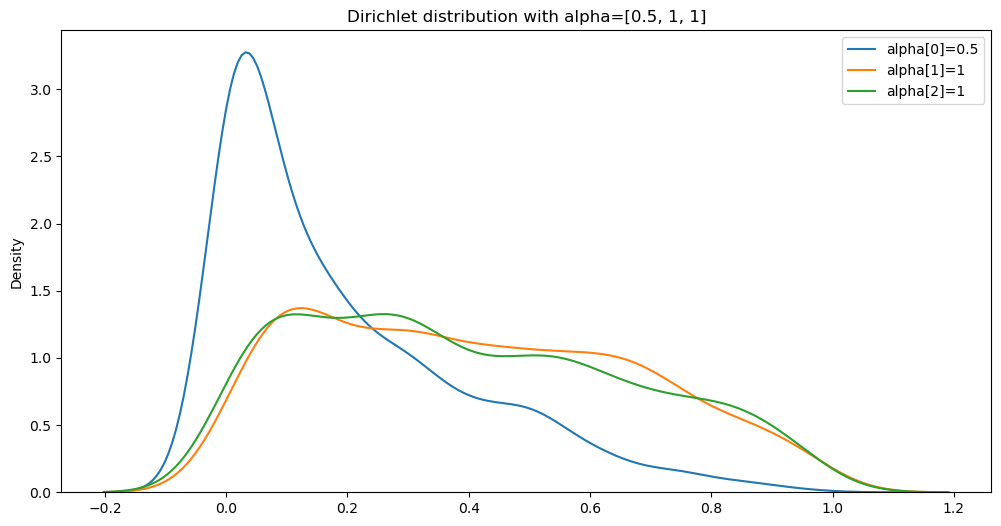

In [421]:
import warnings
warnings.filterwarnings("ignore")
#Plot dirichlet distribution
def plot_dirichlet(alpha, n=1000):
    """
    Plot samples from a Dirichlet distribution with parameter alpha
    """
    samples = np.random.dirichlet(alpha, n)
    plt.figure(figsize=(12, 6))
    for i in range(len(alpha)):
        sns.kdeplot(samples[:, i], label=f'alpha[{i}]={alpha[i]}')
    plt.title(f'Dirichlet distribution with alpha={alpha}')
    plt.legend()
    plt.show()

plot_dirichlet([0.5, 1, 1])

## `Predicting-by-clustering`

Extension of NMP -  predict future movements from a mixing model based on the predictability-maximum partition of the $X_t$, i.e., rather than the entire $X_t$. Considering the conditional independence, we formulate our predicting-by-clustering distribution as:

$$
p(\hat X_t |Z_t,X_t) = \prod_{u \in U_t} (\hat X_{u,t}|X_t^k)
$$

- k = $z_u^t$ is the cluster at time to which subject u belongs
- $X_t^k$ -  is the subset of the movement at time t that contains all the GPS records of the **subjects** from cluster k


Therefore the CityMomentum model involves the mixing of NMP models, each of which is a random walk on the mobility graph constructed by $X_t^k$



CityMomentum is an online predictive model, where according to the definition of the momentary movement, Xt is a
 queue that buffers the GPS records in recent t, and which
 updates the queue as time elapses. As shown in Figure 4, we update the momentary movement queue from time t to t + 1
 by offering the records during the time period from t to t + 1
 and poll the out-of-date records during the time period from
 t 
t to t 
t +1. Accordingly, Xt is updated to Xt+1,
 such that Zt+1 can be inferred and the predicted movement
 Xt+1 follows naturally.

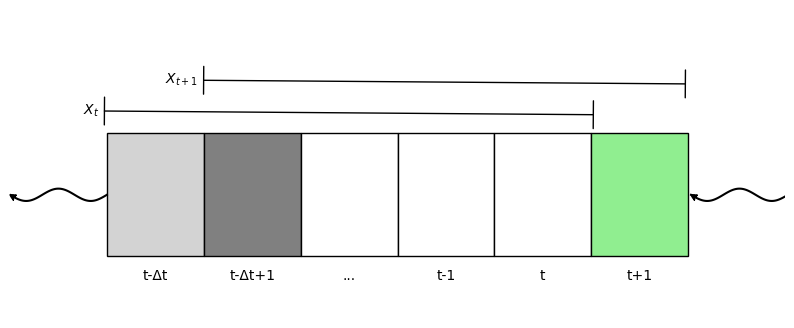

In [422]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 4))

# Draw the grid
rectangles = [
    (0, 0, 1, 1, 'lightgray'),  # First column (t-Δt)
    (1, 0, 1, 1, 'gray'),       # Second column (t-Δt+1)
    (2, 0, 1, 1, 'white'),      # Third column (...)
    (3, 0, 1, 1, 'white'),
    (4, 0, 1, 1, 'white'),
    (5, 0, 1, 1, 'lightgreen'), # Last column (t+1)
]

for (x, y, w, h, color) in rectangles:
    rect = patches.Rectangle((x, y), w, h, facecolor=color, edgecolor='black')
    ax.add_patch(rect)

# Add the labels below the boxes
time_labels = ['t-Δt', 't-Δt+1', '...', 't-1', 't', 't+1']
for i, label in enumerate(time_labels):
    ax.text(i + 0.5, -0.1, label, ha='center', va='top')

"""
# Add arrows to indicate time flow
ax.annotate('', xy=(-0.5, 0.5), xytext=(5.5, 0.5),
            arrowprops=dict(arrowstyle='<->', color='black'))
ax.annotate('', xy=(5.5, 0.5), xytext=(-0.5, 0.5),
            arrowprops=dict(arrowstyle='<->', color='black'))
"""

# Add X_t and X_{t+1} labels for distances

# Horizontal arrow for X_t
ax.annotate('$X_t$', xy=(5.05, 1.15), xytext=(-0.25, 1.15),  # from t-Δt to t
            arrowprops=dict(arrowstyle='|-|', color='black'))

# Horizontal arrow for X_{t+1}
ax.annotate('$X_{t+1}$', xy=(6, 1.4), xytext=(0.6, 1.4),  # from t-Δt to t+1
            arrowprops=dict(arrowstyle='|-|', color='black'))

# Adding wavy arrows on both sides using a custom arrow path
def draw_wavy_arrow(ax, start, end, gamma, n_waves=5):
    x_start, y_start = start
    x_end, y_end = end
    x = np.linspace(x_start, x_end, 100)
    y = y_start -0.05 * np.sin(1.2 * np.pi * n_waves * (x - x_start) / (x_end - x_start) * gamma)
    ax.plot(x, y, color='black')
    ax.annotate('', xy=start, xytext=(x[1], y[1]),
                arrowprops=dict(arrowstyle='fancy', color='black'))

# Left wavy arrow
draw_wavy_arrow(ax, (-1,0.5 ), (0, 1),0.5)

# Right wavy arrow
draw_wavy_arrow(ax, (6.03, 0.5), (7.03, 1),0.5)

# Set limits and remove axes
ax.set_xlim(-1, 7)
ax.set_ylim(-0.5, 2)
ax.axis('off')

plt.show()


In [423]:
ax

<Axes: >

# `Pseudo code 1: Gibbs Sampling Inference`

In [424]:
import numpy as np

def initialize_model(Zt):
    """
    Initialize the model with the current clusters.
    This function should set up any necessary data structures or parameters.
    """
    # Placeholder for model initialization
    pass

def update_model(zut):
    """
    Update the model with the current cluster assignment.
    This function should update the model's state based on the new cluster assignment.
    """
    # Placeholder for model update
    pass

def calculate_likelihood(k):
    """
    Calculate the likelihood for cluster k.
    This function should implement the calculation from Eq. 5.
    """
    # Placeholder for likelihood calculation
    return np.random.random()

def calculate_weight(likelihood):
    """
    Calculate the weight for the given likelihood.
    This function should implement the calculation from Eq. 6.
    """
    # Placeholder for weight calculation
    return np.random.random()

def main(Ut, K, ITERATION):
    Zt = {}
    # Random initialization
    for u in Ut:
        Zt[u] = np.random.randint(K)
    
    initialize_model(Zt)
    
    # Iterative random inference
    for i in range(ITERATION):
        for u in Ut:
            update_model(Zt[u])
            p = np.zeros(K)
            for k in range(K):
                likelihood = calculate_likelihood(k)
                weight = calculate_weight(likelihood)
                p[k] = likelihood * weight
            p /= np.sum(p)  # Normalize to get a probability distribution
            Zt[u] = np.random.choice(K, p=p)
            update_model(Zt[u])
    
    return Zt

# Example usage
Ut = range(10)  # Example set of subjects
K = 5  # Number of clusters
ITERATION = 100  # Number of iterations

Zt = main(Ut, K, ITERATION)
print(Zt)


{0: 2, 1: 1, 2: 2, 3: 4, 4: 0, 5: 4, 6: 0, 7: 0, 8: 2, 9: 3}


In [425]:
import numpy as np
import pandas as pd

# Parameters
num_users = 100  # Number of users
num_records_per_user = 50  # Number of GPS records per user
lat_range = (34.0, 42.0)  # Latitude range (example)
lon_range = (-118.0, -74.0)  # Longitude range (example)
time_range = (0, 10000)  # Time range (arbitrary units)

# Generate random GPS log data
data = {
    'user_id': np.repeat(np.arange(num_users), num_records_per_user),
    'timestamp': np.tile(np.sort(np.random.randint(time_range[0], time_range[1], num_records_per_user)), num_users),
    'latitude': np.random.uniform(lat_range[0], lat_range[1], num_users * num_records_per_user),
    'longitude': np.random.uniform(lon_range[0], lon_range[1], num_users * num_records_per_user),
}

# Create DataFrame
gps_data = pd.DataFrame(data)

# Display the first few rows of the GPS data
print(gps_data.head())

# Initialize clusters
K = 5  # Number of clusters
gps_data['cluster'] = np.random.randint(0, K, len(gps_data))

# Gibbs Sampling parameters
iterations = 10
alpha = 0.5
beta = 0.1
gamma = 0.01

# Initialize Model (e.g., frequency counts)
def initialize_model():
    return np.random.rand(K)  # Placeholder for model initialization

# Update Model (e.g., updating counts or distributions)
def update_model(u, cluster):
    pass  # This would update any model parameters for the specific user/cluster

# Gibbs Sampling Inference
def gibbs_sampling_inference(data, K, iterations):
    for i in range(iterations):
        for idx, row in data.iterrows():
            u = row['user_id']
            current_cluster = row['cluster']

            # Calculate likelihood (Eq. 5)
            likelihoods = np.random.rand(K)  # Placeholder for likelihood calculations

            # Calculate weights (Eq. 6)
            weights = np.random.rand(K)  # Placeholder for weight calculations

            # Compute the posterior distribution p(k)
            p_k = likelihoods * weights
            p_k /= np.sum(p_k)  # Normalize to make it a probability distribution

            # Draw a new cluster assignment from the distribution p(k)
            new_cluster = np.random.choice(np.arange(K), p=p_k)
            data.at[idx, 'cluster'] = new_cluster

            # Update model based on the new cluster assignment
            update_model(u, new_cluster)

        print(f"Iteration {i+1}: Clusters updated.")

# Run Gibbs Sampling Inference
gibbs_sampling_inference(gps_data, K, iterations)

# Display the updated clusters
print(gps_data.head())


   user_id  timestamp   latitude   longitude
0        0        613  37.500863 -115.904803
1        0        956  34.351604  -86.085841
2        0       1289  41.708771  -93.467450
3        0       1420  35.656855  -90.399948
4        0       1464  38.856284  -84.974297


Iteration 1: Clusters updated.
Iteration 2: Clusters updated.
Iteration 3: Clusters updated.
Iteration 4: Clusters updated.
Iteration 5: Clusters updated.
Iteration 6: Clusters updated.
Iteration 7: Clusters updated.
Iteration 8: Clusters updated.
Iteration 9: Clusters updated.
Iteration 10: Clusters updated.
   user_id  timestamp   latitude   longitude  cluster
0        0        613  37.500863 -115.904803        4
1        0        956  34.351604  -86.085841        3
2        0       1289  41.708771  -93.467450        1
3        0       1420  35.656855  -90.399948        3
4        0       1464  38.856284  -84.974297        2


In [426]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from geopy.distance import geodesic

# Generate random GPS data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from geopy.distance import geodesic

def generate_realistic_gps_data(num_records, num_users):
    records = []
    start_time = datetime(2024, 1, 1)

    # Define starting locations for each user
    starting_locations = {
        user_id: (np.random.uniform(-90, 90), np.random.uniform(-180, 180))
        for user_id in range(1, num_users + 1)
    }

    # Define speed profiles for users (in meters per hour)
    speed_profiles = {
        'low': np.random.uniform(1, 5),
        'medium': np.random.uniform(5, 14),
        'high': np.random.uniform(14, 50)
    }

    for user_id in range(1, num_users + 1):
        start_location = starting_locations[user_id]
        speed = np.random.choice(list(speed_profiles.values()))
        current_location = start_location

        for _ in range(num_records // num_users):
            time_interval = np.random.randint(1, 60)  # time interval between records in minutes
            timestamp = start_time + timedelta(minutes=np.random.randint(0, 10000))
            
            # Simulate movement: random direction and distance based on speed
            distance = np.random.uniform(0, speed * time_interval / 60)  # meters
            direction = np.random.uniform(0, 360)  # random direction in degrees
            
            # Calculate new location
            destination = geodesic(meters=distance).destination(current_location, direction)
            new_location = (destination.latitude, destination.longitude)
            
            # Append record
            records.append((user_id, timestamp, new_location[0], new_location[1]))
            
            # Update current location
            current_location = new_location

    return pd.DataFrame(records, columns=['user_id', 'timestamp', 'latitude', 'longitude'])

# Example usage
num_records = 1000
num_users = 10
gps_data = generate_realistic_gps_data(num_records, num_users)

print(gps_data.head())


# Calculate displacements
def calculate_displacements(df):
    displacements = []
    df = df.sort_values(by=['user_id', 'timestamp'])
    for user_id, group in df.groupby('user_id'):
        previous_record = None
        for _, record in group.iterrows():
            if previous_record is not None:
                distance = geodesic(
                    (previous_record['latitude'], previous_record['longitude']),
                    (record['latitude'], record['longitude'])
                ).meters
                displacements.append((user_id, previous_record['timestamp'], record['timestamp'], distance))
            previous_record = record
    return pd.DataFrame(displacements, columns=['user_id', 'start_time', 'end_time', 'distance'])

# Calculate likelihood (Eq. 5)
def calculate_likelihood(x_o, x_d, Z_t, X_t, gamma):
    # Placeholder for likelihood calculation
    user_id_o = x_o['user_id']
    distance = x_d['distance']
    # Example values for counts; replace with actual calculations
    n_I = np.random.randint(1, 10)  # n_{I(x_o)}
    n_D = np.random.randint(1, 10)  # n_{I(x_o),D(x_d,x_o)}
    L = np.random.randint(1, 10)    # L_i(x_o)
    likelihood = (n_I + gamma) / (n_D + L * gamma)
    return likelihood

# Calculate weight (Eq. 6)
def calculate_weight(likelihood, n_t_minus_u, n_t_minus_u_k, alpha, beta, K):
    weight = (n_t_minus_u_k + alpha * n_t_minus_u + beta) / (n_t_minus_u + alpha * K + beta * K)
    return weight

# Gibbs Sampling Inference
def gibbs_sampling_inference(gps_data, num_clusters, num_iterations, gamma, alpha, beta):
    num_users = gps_data['user_id'].nunique()
    cluster_assignments = {user_id: np.random.randint(num_clusters) for user_id in gps_data['user_id'].unique()}
    displacement_data = calculate_displacements(gps_data)
    
    for iteration in range(num_iterations):
        for user_id in gps_data['user_id'].unique():
            current_cluster = cluster_assignments[user_id]
            
            # Update model excluding the current user
            # Example: UpdateModel(user_id, current_cluster)
            
            # Calculate likelihood and weight for each cluster
            likelihoods = []
            weights = []
            for k in range(num_clusters):
                x_o = gps_data[gps_data['user_id'] == user_id].iloc[0]  # Placeholder: use actual records
                x_d = displacement_data[displacement_data['user_id'] == user_id].iloc[0]  # Placeholder: use actual records
                likelihood = calculate_likelihood(x_o, x_d, cluster_assignments, displacement_data, gamma)
                likelihoods.append(likelihood)
                weight = calculate_weight(likelihood, len(gps_data) - 1, np.sum(np.array(list(cluster_assignments.values())) == k), alpha, beta, num_clusters)
                weights.append(weight)
            
            # Draw new cluster assignment
            probabilities = np.array(likelihoods) * np.array(weights)
            new_cluster = np.random.choice(range(num_clusters), p=probabilities / probabilities.sum())
            cluster_assignments[user_id] = new_cluster
            
            # Update model with new assignment
            # Example: UpdateModel(user_id, new_cluster)
    
    return cluster_assignments

# Example usage
num_records = 1000
num_users = 10
num_clusters = 3
num_iterations = 10
gamma = 1.0
alpha = 1.0
beta = 1.0

gps_data = generate_random_gps_data(num_records, num_users)
cluster_assignments = gibbs_sampling_inference(gps_data, num_clusters, num_iterations, gamma, alpha, beta)
print(cluster_assignments)


   user_id           timestamp   latitude  longitude
0        1 2024-01-01 18:22:00  23.840780 -51.116920
1        1 2024-01-05 16:43:00  23.840732 -51.116812
2        1 2024-01-04 14:42:00  23.840793 -51.116726
3        1 2024-01-03 12:14:00  23.840817 -51.116715
4        1 2024-01-04 17:51:00  23.840849 -51.116714


NameError: name 'generate_random_gps_data' is not defined

In [3]:
locations_df = pd.read_csv(r"C:\Users\maorb\CSVs\Locations.csv")

C:\Users\maorb\AppData\Local\Temp\ipykernel_37540\840969264.py:1: DtypeWarning: Columns (14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  locations_df = pd.read_csv(r"C:\Users\maorb\CSVs\Locations.csv")


In [4]:
locations_df.drop(columns=['Unnamed: 17'], inplace=True)

In [5]:
locations_df = locations_df.dropna()    

In [6]:
len(locations_df)

907088

In [7]:
locations_df

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
0,01/12/2017 0:05,0.0,B67,MC DONALD AV/CORTELYOU RD,40.638160,-73.978939,DNTWN BKLYN SANDS ST via FLATBUSH AV,40.700253,-73.987030,NYCT_406,40.671578,-73.977672,7 AV/GARFIELD PL,approaching,130,01/12/2017 0:06,24:01:30
1,01/12/2017 0:06,1.0,Bx7,RIVERDALE AV/W 263 ST,40.912363,-73.902699,WASHINGTON HEIGHTS 166 ST via BROADWAY,40.839813,-73.939745,NYCT_4223,40.866243,-73.925258,BROADWAY/ACADEMY ST,at stop,14,01/12/2017 0:06,23:34:35
2,01/12/2017 0:05,0.0,S51,LINCOLN AV/RICHMOND RD,40.581245,-74.111990,ST GEORGE FERRY via BAY ST,40.643585,-74.072610,NYCT_7080,40.581364,-74.112033,MIDLAND AV/RICHMOND RD,< 1 stop away,209,01/12/2017 0:06,24:15:35
3,01/12/2017 0:05,0.0,M8,WEST ST/CHRISTOPHER ST,40.732847,-74.010081,"AVENUE ""D"" CROSSTOWN",40.724689,-73.974548,NYCT_3809,40.734194,-73.999677,GREENWICH AV/CHRISTOPHER ST,at stop,5,01/12/2017 0:06,24:05:24
4,01/12/2017 0:06,0.0,M101,ASTOR PL/3 AV,40.729567,-73.990052,FT GEORGE 193 ST via 3 AV,40.855666,-73.925259,NYCT_5902,40.773784,-73.957659,3 AV/E 79 ST,approaching,108,01/12/2017 0:06,24:03:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048569,06/12/2017 4:26,1.0,B47,MARCUS GARVEY BLVD/BROADWAY,40.699574,-73.941444,KINGS PLAZA via RALPH AV,40.611007,-73.920407,NYCT_7220,40.662858,-73.922059,ROCKAWAY PY/WINTHROP ST,approaching,54.0,06/12/2017 4:27,4:26:13
1048570,06/12/2017 4:26,1.0,Q20A,COLLEGE PT BL/15 AV,40.784074,-73.845893,JAMAICA MERRICK BL via 20 AV via MAIN S,40.704933,-73.793318,NYCT_7411,40.703726,-73.808748,SUTPHIN BL/90 AV,approaching,71.0,06/12/2017 4:27,4:33:05
1048571,06/12/2017 4:27,1.0,B42,ROCKAWAY PKY SUBWAY/ROCKAWAY PKY SUBWAY,40.645712,-73.902312,CANRSE PIER,40.631428,-73.887285,NYCT_6823,40.633298,-73.889260,ROCKAWAY PY/SCHENCK ST,< 1 stop away,266.0,06/12/2017 4:27,4:27:00
1048572,06/12/2017 4:26,1.0,Q59,QUEENS BL/62 DR,40.731330,-73.864944,WILLIAMSBURG BRIDGE PLZ via GRAND,40.709341,-73.960413,NYCT_7222,40.715680,-73.964305,WYTHE AV/S 1 ST,approaching,105.0,06/12/2017 4:27,4:22:48


In [733]:
# Adjust the selection based on available columns
locations_df_new = locations_df[['RecordedAtTime', 'PublishedLineName', 'OriginLat', 'OriginLong' ,'DestinationLat','DestinationLong','ExpectedArrivalTime']]


In [734]:
locations_df_new = locations_df_new.rename(columns={'RecordedAtTime': 'start_time', 'PublishedLineName': 'user_id', 'DestinationLat': 'Dlatitude', 'DestinationLong': 'Dlongitude',
                                                     'OriginLat': 'Olatitude', 'OriginLong': 'Olongitude', 'ExpectedArrivalTime': 'end_time'})

In [735]:
# Choose every 5th record to reduce the number of data points
locations_df_new ['start_time'] =pd.to_datetime(locations_df_new['start_time'], errors='coerce', format='%m/%d/%Y %H:%M')
locations_df_new ['end_time'] =pd.to_datetime(locations_df_new['end_time'], errors='coerce', format='%m/%d/%Y %H:%M')

In [736]:
locations_df_new['diff'] = locations_df_new['end_time'] - locations_df_new['start_time']

#choose only records with time difference larger than 1 minute
locations_df_new = locations_df_new[locations_df_new['diff'] > '00:01:00']


In [737]:
locations_df_new 

,start_time,user_id,Olatitude,Olongitude,Dlatitude,Dlongitude,end_time,diff
27,2017-01-12 00:06:00,S53,40.622312,-74.028688,40.640296,-74.131330,2017-01-12 00:10:00,0 days 00:04:00
49,2017-01-12 00:06:00,Q44-SBS,40.704907,-73.793306,40.842458,-73.877118,2017-01-12 00:08:00,0 days 00:02:00
57,2017-01-12 00:05:00,Bx28,40.864076,-73.894613,40.860826,-73.822669,2017-01-12 00:07:00,0 days 00:02:00
65,2017-01-12 00:05:00,M55,40.702420,-74.013049,40.755986,-73.982997,2017-01-12 00:07:00,0 days 00:02:00
69,2017-01-12 00:05:00,B46,40.609564,-73.921817,40.709404,-73.959565,2017-01-12 00:07:00,0 days 00:02:00
...,...,...,...,...,...,...,...,...
1048529,2017-06-12 04:26:00,M60-SBS,40.801818,-73.967642,40.768074,-73.862089,2017-06-12 04:29:00,0 days 00:03:00
1048537,2017-06-12 04:26:00,Q43,40.738768,-73.701868,40.700502,-73.807842,2017-06-12 04:31:00,0 days 00:05:00
1048542,2017-06-12 04:26:00,B15,40.699722,-73.941516,40.646909,-73.779564,2017-06-12 04:29:00,0 days 00:03:00
1048543,2017-06-12 04:26:00,Q44-SBS,40.842561,-73.878332,40.704933,-73.793318,2017-06-12 04:29:00,0 days 00:03:00


In [738]:
#Remove letters from the user_id column
locations_df_new['user_id'] = locations_df_new['user_id'].str.extract('(\d+)')

In [739]:
locations_df_new


,start_time,user_id,Olatitude,Olongitude,Dlatitude,Dlongitude,end_time,diff
27,2017-01-12 00:06:00,53,40.622312,-74.028688,40.640296,-74.131330,2017-01-12 00:10:00,0 days 00:04:00
49,2017-01-12 00:06:00,44,40.704907,-73.793306,40.842458,-73.877118,2017-01-12 00:08:00,0 days 00:02:00
57,2017-01-12 00:05:00,28,40.864076,-73.894613,40.860826,-73.822669,2017-01-12 00:07:00,0 days 00:02:00
65,2017-01-12 00:05:00,55,40.702420,-74.013049,40.755986,-73.982997,2017-01-12 00:07:00,0 days 00:02:00
69,2017-01-12 00:05:00,46,40.609564,-73.921817,40.709404,-73.959565,2017-01-12 00:07:00,0 days 00:02:00
...,...,...,...,...,...,...,...,...
1048529,2017-06-12 04:26:00,60,40.801818,-73.967642,40.768074,-73.862089,2017-06-12 04:29:00,0 days 00:03:00
1048537,2017-06-12 04:26:00,43,40.738768,-73.701868,40.700502,-73.807842,2017-06-12 04:31:00,0 days 00:05:00
1048542,2017-06-12 04:26:00,15,40.699722,-73.941516,40.646909,-73.779564,2017-06-12 04:29:00,0 days 00:03:00
1048543,2017-06-12 04:26:00,44,40.842561,-73.878332,40.704933,-73.793318,2017-06-12 04:29:00,0 days 00:03:00


,start_time,user_id,Olatitude,Olongitude,Dlatitude,Dlongitude,end_time,diff


In [193]:
import numpy as np
import pandas as pd
from geopy.distance import geodesic
#import distance





def generate_gps_data(num_users, num_records):
    # Speed profiles
    speed_profiles = {
        'low': lambda: np.random.uniform(1, 5),
        'medium': lambda: np.random.uniform(5, 14),
        'high': lambda: np.random.uniform(14, 50)
    }
    
    # Generate user_ids
    user_ids = np.arange(1, num_users + 1)
    
    # Initialize data storage
    data = {
        'user_id': [],
        'timestamp': [],
        'latitude': [],
        'longitude': []
    }
    
    # Starting time
    start_time = datetime.now()
    
    # Shared origins (3% of users)
    num_shared = max(1, int(0.03 * num_users))
    shared_origins = np.random.uniform(-90, 90, size=(num_shared, 2))  # (lat, lon) for shared origins
    
    # For each user, create records
    for user in user_ids:
        # Assign speed profile
        speed_profile = np.random.choice(['low', 'medium', 'high'])
        speed = speed_profiles[speed_profile]()  # Initial speed
        
        # If the user shares an origin, assign one of the shared origins
        if user <= num_shared:
            lat, lon = shared_origins[user % num_shared]
        else:
            # Otherwise, assign a random origin
            lat, lon = np.random.uniform(-90, 90), np.random.uniform(-180, 180)
        
        # Simulate movement over time
        for t in range(num_records):
            # Gradually update the speed to simulate realistic movement
            speed += np.random.uniform(-0.5, 0.5)  # Speed changes but stays gradual
            
            # Ensure speed stays within reasonable limits
            speed = max(1, min(speed, 50))
            
            # Update latitude and longitude based on the current speed
            lat += np.random.uniform(-0.01, 0.01) * (speed / 10)
            lon += np.random.uniform(-0.01, 0.01) * (speed / 10)
            
            # Add timestamp and data to the records
            timestamp = start_time + timedelta(minutes=t)
            
            data['user_id'].append(user)
            data['timestamp'].append(timestamp)
            data['latitude'].append(lat)
            data['longitude'].append(lon)
            data['speed'].append(speed)
    
    # 3% of users with shared origins will have shared destinations
    num_shared_dest = max(1, int(0.03 * num_shared))
    shared_destinations = np.random.uniform(-90, 90, size=(num_shared_dest, 2))  # (lat, lon) for shared destinations
    
    for user in user_ids[:num_shared]:
        if user % num_shared_dest == 0:
            # Assign a shared destination
            lat_dest, lon_dest = shared_destinations[user % num_shared_dest]
            data['latitude'][-1] = lat_dest
            data['longitude'][-1] = lon_dest
    
    return pd.DataFrame(data)

import numpy as np
import pandas as pd
from geopy import distance
from datetime import datetime, timedelta

def determine_direction(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    
    if delta_lat > 0 and delta_lon > 0:
        return 'North-East'
    elif delta_lat > 0 and delta_lon < 0:
        return 'North-West'
    elif delta_lat < 0 and delta_lon > 0:
        return 'South-East'
    elif delta_lat < 0 and delta_lon < 0:
        return 'South-West'
    elif delta_lat == 0 and delta_lon > 0:
        return 'East'
    elif delta_lat == 0 and delta_lon < 0:
        return 'West'
    elif delta_lat > 0 and delta_lon == 0:
        return 'North'
    elif delta_lat < 0 and delta_lon == 0:
        return 'South'
    else:
        return 'Undefined'

def compute_displacement_type(df, speed_thresholds, k):
    # Check if required columns exist
    required_columns = ['Olatitude', 'Olongitude', 'Dlatitude', 'Dlongitude', 'start_time', 'end_time', 'user_id']
    for col in required_columns:
        if col not in df.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame")
    
    displacements = []
    for _, record in df.iterrows():
        origin_coords = (record['Olatitude'], record['Olongitude'])
        destination_coords = (record['Dlatitude'], record['Dlongitude'])
        
        ds = distance.distance(origin_coords, destination_coords).kilometers
        time_diff = (record['end_time'] - record['start_time']).total_seconds() / 3600
        
        speed = (ds / time_diff) if time_diff > 0 else 0
        
        if speed < speed_thresholds['low']:
            speed_level = 'Low'
        elif speed_thresholds['low'] <= speed < speed_thresholds['medium']:
            speed_level = 'Medium'
        else:
            speed_level = 'High'
        
        direction = determine_direction(origin_coords, destination_coords) if speed_level != 'Low' else 'Undefined'
        cluster_random = np.random.randint(0, k)
        
        displacements.append({
            'user_id': record['user_id'],
            'start_time': record['start_time'],
            'end_time': record['end_time'],
            'distance': ds,
            'speed': speed,
            'speed_level': speed_level,
            'direction': direction,
            
        })
    
    return pd.DataFrame(displacements)




def user_id_df2(df,k):
    df = compute_displacement_type(df, speed_thresholds,k)
    speed_levels = ['Medium', 'High']
    directions = ['North-East', 'North-West', 'South-East', 'South-West'] 
    user_id = df['user_id']   
    # Initialize a dictionary to store counts for each combination of speed level and direction
    counts = {f'{speed}_{direction}': np.array([len(df[(df['user_id'] == i) & 
                                                      (df['speed_level'] == speed) & 
                                                      (df['direction'] == direction)]) 
                                                for i in user_id])
              for speed in speed_levels for direction in directions}

    # Total counts for each speed level across all directions
    counts['low'] = np.array([len(df[(df['user_id'] == i) & (df['speed_level'] == 'Low')]) for i in user_id])
    counts['medium'] = np.array([len(df[(df['user_id'] == i) & (df['speed_level'] == 'Medium')]) for i in user_id])
    counts['high'] = np.array([len(df[(df['user_id'] == i) & (df['speed_level'] == 'High')]) for i in user_id])
    
    # Total counts across all speed levels and directions
    counts['total'] = counts['low'] + counts['medium'] + counts['high']
    
    # Add user_id to the DataFrame
    counts['user_id'] = user_id

    
    return pd.DataFrame(counts)


def user_id_df(df,k):
    df = compute_displacement_type(df, speed_thresholds,k)
    speed_levels = ['Medium', 'High']
    directions = ['North-East', 'North-West', 'South-East', 'South-West']
    user_id = df['user_id'].unique()
    
    # Initialize a dictionary to store counts for each combination of speed level and direction
    counts = {f'{speed}_{direction}': np.array([len(df[(df['user_id'] == i) & 
                                                      (df['speed_level'] == speed) & 
                                                      (df['direction'] == direction)]) 
                                                for i in user_id])
              for speed in speed_levels for direction in directions}

    # Total counts for each speed level across all directions
    counts['low'] = np.array([len(df[(df['user_id'] == i) & (df['speed_level'] == 'Low')]) for i in user_id])
    counts['medium'] = np.array([len(df[(df['user_id'] == i) & (df['speed_level'] == 'Medium')]) for i in user_id])
    counts['high'] = np.array([len(df[(df['user_id'] == i) & (df['speed_level'] == 'High')]) for i in user_id])
    
    # Total counts across all speed levels and directions
    counts['total'] = counts['low'] + counts['medium'] + counts['high']
    
    # Add user_id to the DataFrame
    counts['user_id'] = user_id
    
    return pd.DataFrame(counts)



def Random_Z_t_u(df,specific_date,k):
    df['cluster'] = np.random.randint(0, k, len(df))
    return df

def calculate_likelihood_user_cluster(df, gamma, user_id,cluster,k): 
    #without the user_id
    #loc_d = compute_displacement_type(df, speed_thresholds,k)
    users_list = df['user_id'].unique()
    randl_df = user_id_df(df,k)
    users_latitude_vec = [df[df['user_id'] == user]['Dlatitude'].unique() for user in users_list]
    users_longitude_vec = [df[df['user_id'] == user]['Dlongitude'].unique() for user in users_list]
    if len(users_latitude_vec) < len(users_longitude_vec):
        total_unique_end_location = users_latitude_vec
    else:
        total_unique_end_location = users_longitude_vec
    user_list = randl_df[randl_df['user_id'] != user_id]
    user_list_c = user_list[user_list['cluster'] == cluster]
    #print(user_list_c)
    user_id = user_list_c['user_id']
    total = user_list_c['total'].values
    displacement_cols = user_list_c.iloc[:,:9].values
    likelihood_parts = [(displacement_cols[i] + gamma)/(total[i] + len(total_unique_end_location[j]) * gamma) for i,j in zip(range(len(total)),range(len(total_unique_end_location)))]
    print(likelihood_parts)
    #likelihood = (displacement_cols + gamma)/(99 + 99 * gamma)
    prod_per_user = np.prod(likelihood_parts, axis = 1)
    #For now we'll sum it but maybe we need something else
    #likelihood = np.sum(prod_per_user)
    return prod_per_user


def calculate_likelihood_user_cluster2(df, gamma, user_id, cluster, k): 
    users_list = df['user_id'].unique()
    randl_df = user_id_df(df, k)
    
    # Extract unique latitude and longitude vectors for each user
    users_latitude_vec = [df[df['user_id'] == user]['Dlatitude'].unique() for user in users_list]
    users_longitude_vec = [df[df['user_id'] == user]['Dlongitude'].unique() for user in users_list]
    
    # Determine total unique end locations
    if len(users_latitude_vec) < len(users_longitude_vec):
        total_unique_end_location = users_latitude_vec
    else:
        total_unique_end_location = users_longitude_vec
    
    # Filter out the target user and select users in the same cluster
    user_list = randl_df[randl_df['user_id'] != user_id]
    user_list_c = user_list[user_list['cluster'] == cluster]
    
    # Extract user IDs, total counts, and displacement columns
    total = user_list_c['total'].values
    print(total)
    displacement_cols = user_list_c.iloc[:, :9].values  # Assuming 9 displacement columns
    
    # Calculate likelihood parts for each displacement
    likelihood_parts = [(displacement_cols[m] + gamma) / 
                        (total[i] + len(total_unique_end_location[j]) * gamma) 
                        for i, j in zip(range(len(total)), range(len(total_unique_end_location)))]
    
    # Take the product of all likelihood parts to get the final likelihood
    final_likelihood = np.prod(likelihood_parts)
    
    return final_likelihood


def weight_likelihood_cluster_user(df, previous_clustered, alpha, beta, cluster,cluster_num,user_id, specific_date):
    m_user_df = df[(df['user_id'] !=user_id) & (df['start_time'] == specific_date)]
    m_user_list = m_user_df['user_id'].unique()
    total_timestamp = len(m_user_list)
    m_user_cluster_df = m_user_df[m_user_df['cluster'] == cluster]
    m_users_c = m_user_cluster_df['user_id'].unique()
    cluster_total_timestamp = len(m_users_c)
    total_prev = len(previous_clustered['user_id'].unique())
    user_cluster_p = previous_clustered[previous_clustered['cluster'] == cluster]
    users_c_p = user_cluster_p['user_id'].unique()
    cluster_prev_total = len(users_c_p)
    weight = (cluster_total_timestamp + alpha * cluster_prev_total + beta)/(total_timestamp + alpha * total_prev + beta * cluster_num)
    return weight

speed_thresholds =  {'low': 80, 'medium': 120}

def sampling_gibbs_whoo(df, num_clusters, num_iterations, gamma, alpha, beta, specific_date1,k):
    user_df = user_id_df(df,k)
    specific_date1 = datetime.strptime(specific_date1, '%m/%d/%Y %H:%M')
    prev_date = specific_date1 - timedelta(hours=1)
    prev_date = prev_date.strftime('%m/%d/%Y %H:%M')
    previous_clustered = Random_Z_t_u(user_df,prev_date,num_clusters)
    print('past_random2')
    #initialize the cluster
    cluster_assignments = {user_id: np.random.randint(num_clusters) for user_id in df1['user_id'].unique()}
    for iteration in range(num_iterations):
        for user_id in df1['user_id'].unique():
            current_cluster = cluster_assignments[user_id]
            #Update model excluding the current user
            #Calculate likelihood and weight for each cluster
            likelihoods = []
            weights = []
            for k in range(num_clusters):
                likelihood, prod_per_user = calculate_likelihood_user_cluster(df1, gamma, user_id, num_clusters,k)
                likelihoods.append(likelihood)
                weight = weight_likelihood_cluster_user(df1, previous_clustered, alpha, beta, k, num_clusters, user_id)
                weights.append(weight)
            #Draw new cluster assignment
            probabilities = np.array(likelihoods) * np.array(weights)            
            new_cluster = np.random.choice(range(num_clusters), p=probabilities / probabilities.sum())
            cluster_assignments[user_id] = new_cluster  
    return cluster_assignments

def sampling_gibbs_whoo_new(df, num_clusters, num_iterations, gamma, alpha, beta, specific_date1, k):
    #displacement_data = compute_displacement_type(df, speed_thresholds, k)
    print('past_displacement')
    
    specific_date1 = datetime.strptime(specific_date1, '%m/%d/%Y %H:%M')
    df1 = Random_Z_t_u(df, specific_date1, num_clusters)
    print(df1)
    
    prev_date = specific_date1 - timedelta(hours=1)
    prev_date = prev_date.strftime('%m/%d/%Y %H:%M')
    previous_clustered = Random_Z_t_u(df, prev_date, num_clusters)
    print('past_random2')
    
    cluster_assignments = {user_id: np.random.randint(num_clusters) for user_id in df1['user_id'].unique()}
    
    for iteration in range(num_iterations):
        for user_id in df1['user_id'].unique():
            current_cluster = cluster_assignments[user_id]
            likelihoods = []
            weights = []
            for k in range(num_clusters):
                likelihood, _ = calculate_likelihood_user_cluster(df1, gamma, user_id, k, k)
                likelihoods.append(likelihood)
                weight = weight_likelihood_cluster_user(df1, previous_clustered, alpha, beta, k, num_clusters, user_id)
                weights.append(weight)
            probabilities = np.array(likelihoods) * np.array(weights)
            new_cluster = np.random.choice(range(num_clusters), p=probabilities / probabilities.sum())
            cluster_assignments[user_id] = new_cluster
    
    return cluster_assignments


 $$
p(x_d|x_o,Z_{t,-u}^k,X_{t,-u}^k) = \frac{n_{I(x_o),D(x_d,x_o)}^k + \gamma}{\sum_{D} n_{I(x_o),D(x_d,x_o)}^k + L_i(x_o) \cdot \gamma}
 $$
 
$$
p(X_{t,u}|z_u^t =k,X_{t,-u}^k) \quad \propto \prod_{(x_o,x_d) \in T_u(X_t)} p(x_d|x_o,Z_{t,-u}^k,X_{t,-u}^k)
$$

 $$
p(z_u^t = k|Z_{t,-u},Z_{t-1}) = \frac{n_{t,-u}^k + \alpha n_{t-1}^k + \beta}{n_{t,-u}+ \alpha n_{t-1} + \beta K}  
$$



In [310]:
previous_time = datetime.strptime('2017-01-12 01:06:00', '%Y-%m-%d %H:%M:%S') - timedelta(hours=1)
# reformat the date
previous_time = previous_time.strftime('%Y-%m-%d %H:%M:%S')


In [354]:
cluster_assignments = {user_id: np.random.randint(2) for user_id in locations_df_new[:500]['user_id'].unique()}

In [443]:
weight_likelihood_cluster_user(locations_df_new[:500], 1, 1, 1, 1, 1, '2017-01-12 01:06:00',cluster_assignments)

0.41935483870967744

In [341]:
locations_df_new[:500][locations_df_new[:500]['start_time'] == '2017-01-12 01:06:00']

,start_time,user_id,Olatitude,Olongitude,Dlatitude,Dlongitude,end_time,diff
3678,2017-01-12 01:06:00,M57,40.759310,-73.959464,40.778765,-73.982253,2017-01-12 01:08:00,0 days 00:02:00
3710,2017-01-12 01:06:00,Q43,40.738768,-73.701868,40.700502,-73.807842,2017-01-12 01:14:00,0 days 00:08:00
3716,2017-01-12 01:06:00,Q48,40.759584,-73.830302,40.768643,-73.868269,2017-01-12 01:11:00,0 days 00:05:00
3743,2017-01-12 01:06:00,M60-SBS,40.801818,-73.967642,40.768074,-73.862089,2017-01-12 01:09:00,0 days 00:03:00
3748,2017-01-12 01:06:00,Q59,40.709355,-73.960436,40.731204,-73.864458,2017-01-12 01:08:00,0 days 00:02:00
3789,2017-01-12 01:06:00,Bx31,40.840864,-73.842457,40.902777,-73.868318,2017-01-12 01:08:00,0 days 00:02:00
3859,2017-01-12 01:06:00,B11,40.645419,-74.023199,40.632009,-73.947727,2017-01-12 01:08:00,0 days 00:02:00
3860,2017-01-12 01:06:00,M103,40.803886,-73.937851,40.711746,-74.007380,2017-01-12 01:09:00,0 days 00:03:00
3868,2017-01-12 01:06:00,B60,40.650074,-73.891470,40.709534,-73.959549,2017-01-12 01:08:00,0 days 00:02:00
3869,2017-01-12 01:06:00,Q44-SBS,40.704907,-73.793306,40.842458,-73.877118,2017-01-12 01:13:00,0 days 00:07:00


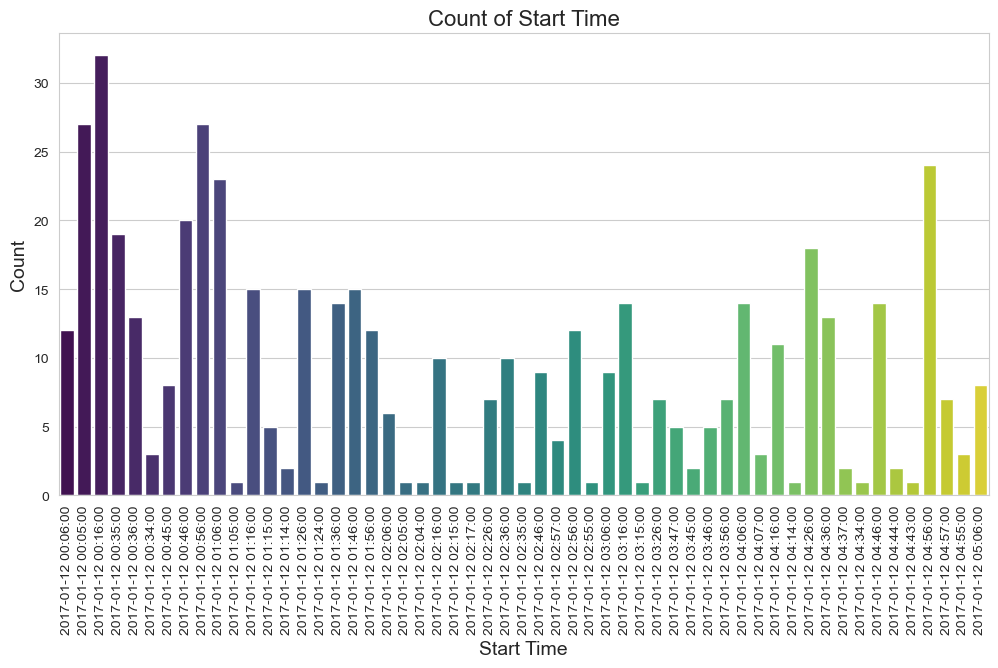

In [334]:
#Bar plot for 'start_time'
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot the data
sns.countplot(x='start_time', data=locations_df_new[:500], palette='viridis')

#change angle of x-axis labels
plt.xticks(rotation=90)

# Set the title and labels
plt.title('Count of Start Time', fontsize=16)
plt.xlabel('Start Time', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Display the plot
plt.show()


# `Last clustering function`

In [454]:
import numpy as np

def random_Z_t_u1(df, k):
    return np.random.randint(0, k, len(df))

def compute_displacement_type(df, speed_thresholds):
    # Check if required columns exist
    required_columns = ['Olatitude', 'Olongitude', 'Dlatitude', 'Dlongitude', 'start_time', 'end_time', 'user_id']
    for col in required_columns:
        if col not in df.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame")
    
    displacements = []
    for _, record in df.iterrows():
        origin_coords = (record['Olatitude'], record['Olongitude'])
        destination_coords = (record['Dlatitude'], record['Dlongitude'])
        
        ds = distance.distance(origin_coords, destination_coords).kilometers
        time_diff = (record['end_time'] - record['start_time']).total_seconds() / 3600
        
        speed = (ds / time_diff) if time_diff > 0 else 0
        
        if speed < speed_thresholds['low']:
            speed_level = 'Low'
        elif speed_thresholds['low'] <= speed < speed_thresholds['medium']:
            speed_level = 'Medium'
        else:
            speed_level = 'High'
        
        direction = determine_direction(origin_coords, destination_coords) if speed_level != 'Low' else 'Undefined'
        
        displacements.append({
            'user_id': record['user_id'],
            'start_time': record['start_time'],
            'end_time': record['end_time'],
            'distance': ds,
            'speed': speed,
            'speed_level': speed_level,
            'direction': direction,
            
        })
    
    return pd.DataFrame(displacements)

def user_id_df(df):
    df = compute_displacement_type(df, speed_thresholds)
    speed_levels = ['Medium', 'High']
    directions = ['North-East', 'North-West', 'South-East', 'South-West']
    user_id = df['user_id'].unique()
    
    # Initialize a dictionary to store counts for each combination of speed level and direction
    counts = {f'{speed}_{direction}': np.array([len(df[(df['user_id'] == i) & 
                                                      (df['speed_level'] == speed) & 
                                                      (df['direction'] == direction)]) 
                                                for i in user_id])
              for speed in speed_levels for direction in directions}

    # Total counts for each speed level across all directions
    counts['low'] = np.array([len(df[(df['user_id'] == i) & (df['speed_level'] == 'Low')]) for i in user_id])
    counts['medium'] = np.array([len(df[(df['user_id'] == i) & (df['speed_level'] == 'Medium')]) for i in user_id])
    counts['high'] = np.array([len(df[(df['user_id'] == i) & (df['speed_level'] == 'High')]) for i in user_id])
    
    # Total counts across all speed levels and directions
    counts['total'] = counts['low'] + counts['medium'] + counts['high']
    
    # Add user_id to the DataFrame
    counts['user_id'] = user_id
    
    return pd.DataFrame(counts)

    

def calculate_likelihood_user_cluster_chat(randl_df,df, gamma, user_id, cluster,previous_cluster): 
    #users_list = df['user_id'].unique()
    #randl_df = user_id_df(df)
    randl_df['cluster'] = randl_df['user_id'].map(previous_cluster)
    cluster_users = randl_df[randl_df['cluster'] == cluster]['cluster'].unique()
    # Extract unique latitude and longitude vectors for each user
    users_latitude_vec = [df[df['user_id'] == user]['Dlatitude'].unique() for user in cluster_users]
    users_longitude_vec = [df[df['user_id'] == user]['Dlongitude'].unique() for user in cluster_users]
    
    # Determine total unique end locations (x_o)
    if len(users_latitude_vec) < len(users_longitude_vec):
        total_unique_end_location = users_latitude_vec
    else:
        total_unique_end_location = users_longitude_vec
    
    # Filter out the target user and select users in the same cluster
    user_list = randl_df[randl_df['user_id'] != user_id]
    user_list_c = user_list[user_list['cluster'] == cluster]
    
    # Extract user IDs, total counts, and displacement columns
    total = user_list_c['total'].values
    displacement_cols = user_list_c.iloc[:, :9].values  # Assuming 9 displacement columns
    
    # Initialize a list to store the likelihood for each displacement type (9 in total)
    likelihoods = np.zeros(9)
    
    # Loop over all displacement types (D(x_d, x_o)) and calculate likelihood for each
    for i in range(9):  # For each displacement type (i.e., speed + direction combination)
        likelihood_part_sum = 0  # Accumulate the sum for this displacement type
        
        for j in range(len(total_unique_end_location)):  # For each starting location x_o
            # Calculate the likelihood part for the current displacement type and starting location
            # Note that displacement_cols[:, i] gives the count for displacement type i
            likelihood_part = (displacement_cols[j, i] + gamma) / (
                total + len(total_unique_end_location[j]) * gamma)
            
            # Sum the likelihoods across all starting locations for this displacement type
            likelihood_part_sum += np.sum(likelihood_part)
        
        # Store the final likelihood for this displacement type
        likelihoods[i] = likelihood_part_sum
    # Multiply all 9 likelihoods to get the final joint probability (product of all displacement type likelihoods)
    final_likelihood = np.prod(likelihoods)
    
    return min(final_likelihood,1)

def weight_likelihood_cluster_user(df, alpha, beta, cluster,cluster_num,user_id, specific_date,previous_cluster):
    previous_time = datetime.strptime(specific_date, '%Y-%m-%d %H:%M:%S') - timedelta(hours=1)
    # reformat the date
    previous_time = previous_time.strftime('%Y-%m-%d %H:%M:%S')
    df['cluster'] = df['user_id'].map(previous_cluster)
    previous_clustered =  df[(df['user_id'] !=user_id) & (df['start_time'] == previous_time)]
    total_prev = len(previous_clustered['user_id'].unique())
    user_cluster_p = previous_clustered[previous_clustered['cluster'] == cluster]
    users_c_p = user_cluster_p['user_id'].unique()
    cluster_prev_total = len(users_c_p)
    curr_user_df = df[(df['user_id'] !=user_id) & (df['start_time'] == specific_date)]
    curr_user_list = curr_user_df['user_id'].unique()
    total_timestamp = len(curr_user_list)
    m_user_cluster_df = curr_user_df[curr_user_df['cluster'] == cluster]
    m_users_c = m_user_cluster_df['user_id']
    cluster_total_timestamp = len(m_users_c)
    weight = (cluster_total_timestamp + alpha * cluster_prev_total + beta)/(total_timestamp + alpha * total_prev + beta * cluster_num)
    return weight

def Final_Clustering(df, num_clusters, num_iterations, gamma, alpha, beta, specific_date1,k):
    cluster_assignments = {user_id: np.random.randint(num_clusters) for user_id in df['user_id'].unique()}
    for iteration in range(num_iterations):
        for user_id in df['user_id'].unique():
            current_cluster = cluster_assignments[user_id]
            #Update model excluding the current user
            #Calculate likelihood and weight for each cluster
            likelihoods = []
            weights = []
            for k in range(num_clusters):
                likelihood = calculate_likelihood_user_cluster_chat(df, gamma, user_id, k, num_clusters, cluster_assignments)
                likelihoods.append(likelihood)
                weight = weight_likelihood_cluster_user(df, alpha, beta, k, num_clusters, user_id, specific_date1, cluster_assignments)
                weights.append(weight)
            #Draw new cluster assignment
            probabilities = np.array(likelihoods) * np.array(weights)            
            new_cluster = np.random.choice(range(num_clusters), p=probabilities / probabilities.sum())
            cluster_assignments[user_id] = new_cluster 

    return cluster_assignments


In [583]:
cluster_assignments = {user_id: np.random.randint(2) for user_id in locations_df_new[:500]['user_id'].unique()}

In [585]:
weight_likelihood_cluster_user(locations_df_new[:500], 1, 1, 1, 1,1, '2017-01-12 01:06:00',cluster_assignments)

0.5161290322580645

In [625]:
df_d['cluster'] = df_d['user_id'].map(cluster_assignments)
cluster_users = df_d[df_d['cluster'] == 1]['user_id'].unique()
    
    # Extract unique latitude and longitude vectors for each user in the cluster
users_latitude_vec = [locations_df_new[:500][locations_df_new[:500]['user_id'] == user]['Dlatitude'].unique() for user in cluster_users]


In [633]:
cluster_users

array(['B15', 'X27', 'Q27', 'Bx24', 'Bx12', 'M Shuttle Bus', 'Q84', 'Q3',
       'B38', 'Q48', 'Q85', 'B67', 'M11', 'M96', 'X28', 'B14', 'Bx22',
       'Bx36', 'Bx15', 'Bx6', 'B1', 'M34-SBS', 'M50', 'B43', 'Bx42', 'M3',
       'Bx35', 'M20', 'B44', 'M34A-SBS', 'Bx13', 'B41', 'B62', 'Q56',
       'Bx29', 'B47', 'M31', 'S59', 'Bx5', 'Q59', 'Bx31', 'B60', 'B68',
       'M66', 'Bx40', 'Q83', 'S46', 'B13', 'B36', 'B26', 'B52', 'B61',
       'Q2', 'B35', 'S48', 'Q46', 'M79-SBS', 'M102', 'M23-SBS', 'X17J'],
      dtype=object)

array(['B15', 'X27', 'Q27', 'Bx24', 'Bx12', 'M Shuttle Bus', 'Q84', 'Q3',
       'B38', 'Q48', 'Q85', 'B67', 'M11', 'M96', 'X28', 'B14', 'Bx22',
       'Bx36', 'Bx15', 'Bx6', 'B1', 'M34-SBS', 'M50', 'B43', 'Bx42', 'M3',
       'Bx35', 'M20', 'B44', 'M34A-SBS', 'Bx13', 'B41', 'B62', 'Q56',
       'Bx29', 'B47', 'M31', 'S59', 'Bx5', 'Q59', 'Bx31', 'B60', 'B68',
       'M66', 'Bx40', 'Q83', 'S46', 'B13', 'B36', 'B26', 'B52', 'B61',
       'Q2', 'B35', 'S48', 'Q46', 'M79-SBS', 'M102', 'M23-SBS', 'X17J'],
      dtype=object)

In [742]:
def calculate_likelihood_user_cluster_chat(randl_df, df, gamma, user_id, cluster, previous_cluster):
    # Map clusters to users
    randl_df['cluster'] = randl_df['user_id'].map(previous_cluster)
    cluster_users = randl_df[randl_df['cluster'] == cluster]['user_id'].unique()


    
    # Extract unique latitude and longitude vectors for each user in the cluster
    users_latitude_vec = [df[df['user_id'] == user]['Dlatitude'].unique() for user in cluster_users]
    users_longitude_vec = [df[df['user_id'] == user]['Dlongitude'].unique() for user in cluster_users]

    # Determine total unique end locations (x_o)
    total_unique_end_location = users_latitude_vec if len(users_latitude_vec) < len(users_longitude_vec) else users_longitude_vec
    # Filter out the target user and select users in the same cluster
    user_list = randl_df[randl_df['user_id'] != user_id]
    user_list_c = user_list[user_list['cluster'] == cluster]
    
    # Extract user IDs, total counts, and displacement columns
    total = user_list_c['total'].values
    displacement_cols = user_list_c.iloc[:, :9].values  # Assuming 9 displacement columns

    # Determine 'tot' based on displacement columns
    if displacement_cols.shape[0] == 0 or displacement_cols.shape[1] != 9:
        tot = min(len(displacement_cols), len(total_unique_end_location))
    else:
        tot = len(total_unique_end_location)
    
    # Initialize a list to store the likelihood for each displacement type (9 in total)
    likelihoods = np.zeros(9)
    
    # Loop over all displacement types (D(x_d, x_o)) and calculate likelihood for each
    for i in range(9):  # For each displacement type (i.e., speed + direction combination)
        likelihood_part_sum = 0  # Accumulate the sum for this displacement type
        
        for j in range(tot):  # For each starting location x_o
            # Calculate the likelihood part for the current displacement type and starting location
            # Note: Ensure j is within bounds for displacement_cols
   
            likelihood_part = (displacement_cols[j, i] + gamma) / (
                total[j] + len(total_unique_end_location[j]) * gamma)  # Corrected total calculation
            likelihood_part_sum += likelihood_part
        
        # Store the final likelihood for this displacement type
        likelihoods[i] = likelihood_part_sum/9
    # Multiply all 9 likelihoods to get the final joint probability (product of all displacement type likelihoods)
    final_likelihood = np.prod(likelihoods)
    
    return min(final_likelihood, 1)

# Call the function
cluster_assignments = {user_id: np.random.randint(5) for user_id in locations_df_new[:500]['user_id'].unique()}
df_d = user_id_df(locations_df_new[:500])
calculate_likelihood_user_cluster_chat(df_d, locations_df_new[:500], 0.01, 3, 4, cluster_assignments)


1.915131355177566e-08

In [806]:
cluster_assignments = {user_id: np.random.randint(5) for user_id in locations_df_new[:500]['user_id'].unique()}
df_d = user_id_df(locations_df_new[:500])
calculate_likelihood_user_cluster_chat(df_d, locations_df_new[:500], 0.1, 3, 4, cluster_assignments)

6.74303800672232e-08

 $$
p(x_d|x_o,Z_{t,-u}^k,X_{t,-u}^k) = \frac{n_{I(x_o),D(x_d,x_o)}^k + \gamma}{\sum_{D} n_{I(x_o),D(x_d,x_o)}^k + L_i(x_o) \cdot \gamma}
 $$
 
$$
p(X_{t,u}|z_u^t =k,X_{t,-u}^k) \quad \propto \prod_{(x_o,x_d) \in T_u(X_t)} p(x_d|x_o,Z_{t,-u}^k,X_{t,-u}^k)
$$

Final

In [786]:
## Chat maybe optimized version

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from geopy import distance

# Generate random cluster assignments for initial clusters
def random_Z_t_u1(df, k):
    return np.random.randint(0, k, len(df))

# Compute displacement type
def compute_displacement_type(df, speed_thresholds):
    required_columns = ['Olatitude', 'Olongitude', 'Dlatitude', 'Dlongitude', 'start_time', 'end_time', 'user_id']
    if not all(col in df.columns for col in required_columns):
        raise KeyError(f"Missing required columns in DataFrame")

    def calc_displacement(record):
        origin_coords = (record['Olatitude'], record['Olongitude'])
        destination_coords = (record['Dlatitude'], record['Dlongitude'])
        ds = distance.distance(origin_coords, destination_coords).kilometers
        time_diff = (record['end_time'] - record['start_time']).total_seconds() / 3600
        speed = ds / time_diff if time_diff > 0 else 0
        return ds, speed
    
    displacements = []
    for _, record in df.iterrows():
        ds, speed = calc_displacement(record)
        speed_level = 'Low' if speed < speed_thresholds['low'] else 'Medium' if speed < speed_thresholds['medium'] else 'High'
        direction = determine_direction((record['Olatitude'], record['Olongitude']),
                                        (record['Dlatitude'], record['Dlongitude'])) if speed_level != 'Low' else 'Undefined'
        displacements.append({'user_id': record['user_id'], 'start_time': record['start_time'],
                              'end_time': record['end_time'], 'distance': ds, 'speed': speed,
                              'speed_level': speed_level, 'direction': direction})
    
    return pd.DataFrame(displacements)

# Generate user displacement data with counts for each user
def user_id_df(df):
    df = compute_displacement_type(df, speed_thresholds)
    speed_levels = ['Medium', 'High']
    directions = ['North-East', 'North-West', 'South-East', 'South-West']
    user_id = df['user_id'].unique()
    
    # Initialize a dictionary to store counts for each combination of speed level and direction
    counts = {}
    
    for speed in speed_levels:
        for direction in directions:
            # Ensure we get the correct 1D array of counts for each user_id
            counts[f'{speed}_{direction}'] = [len(df[(df['user_id'] == i) & 
                                                    (df['speed_level'] == speed) & 
                                                    (df['direction'] == direction)]) 
                                              for i in user_id]
    
    # Total counts for each speed level across all directions
    counts['low'] = [len(df[(df['user_id'] == i) & (df['speed_level'] == 'Low')]) for i in user_id]
    counts['medium'] = [len(df[(df['user_id'] == i) & (df['speed_level'] == 'Medium')]) for i in user_id]
    counts['high'] = [len(df[(df['user_id'] == i) & (df['speed_level'] == 'High')]) for i in user_id]
    
    # Total counts across all speed levels and directions
    counts['total'] = np.array(counts['low']) + np.array(counts['medium']) + np.array(counts['high'])
    
    # Add user_id to the DataFrame
    counts['user_id'] = user_id
    
    return pd.DataFrame(counts)



def calculate_likelihood_user_cluster_chat(randl_df, df, gamma, user_id, cluster, previous_cluster):
    # Map clusters to users
    randl_df['cluster'] = randl_df['user_id'].map(previous_cluster)
    cluster_users = randl_df[randl_df['cluster'] == cluster]['user_id'].unique()
    if len(cluster_users) == 0:
        return 0

    
    # Extract unique latitude and longitude vectors for each user in the cluster
    users_latitude_vec = [df[df['user_id'] == user]['Dlatitude'].unique() for user in cluster_users]
    users_longitude_vec = [df[df['user_id'] == user]['Dlongitude'].unique() for user in cluster_users]

    # Determine total unique end locations (x_o)
    total_unique_end_location = users_latitude_vec if len(users_latitude_vec) < len(users_longitude_vec) else users_longitude_vec
    # Filter out the target user and select users in the same cluster
    user_list = randl_df[randl_df['user_id'] != user_id]
    user_list_c = user_list[user_list['cluster'] == cluster]
    
    # Extract user IDs, total counts, and displacement columns
    total = user_list_c['total'].values
    displacement_cols = user_list_c.iloc[:, :9].values  # Assuming 9 displacement columns

    # Determine 'tot' based on displacement columns
    if displacement_cols.shape[0] == 0 or displacement_cols.shape[1] != 9:
        tot = min(len(displacement_cols), len(total_unique_end_location))
    else:
        tot = len(total_unique_end_location)
    
    # Initialize a list to store the likelihood for each displacement type (9 in total)
    likelihoods = np.zeros(9)
    
    # Loop over all displacement types (D(x_d, x_o)) and calculate likelihood for each
    for i in range(9):  # For each displacement type (i.e., speed + direction combination)
        likelihood_part_sum = 0  # Accumulate the sum for this displacement type
        
        for j in range(tot):  # For each starting location x_o
            # Calculate the likelihood part for the current displacement type and starting location
            # Note: Ensure j is within bounds for displacement_cols
   
            likelihood_part = (displacement_cols[j, i] + gamma) / (
                total[j] + len(total_unique_end_location[j]) * gamma)  # Corrected total calculation
            likelihood_part_sum += likelihood_part
        
        # Store the final likelihood for this displacement type
        likelihoods[i] = likelihood_part_sum/9
    # Multiply all 9 likelihoods to get the final joint probability (product of all displacement type likelihoods)
    final_likelihood = np.prod(likelihoods)
    
    return min(final_likelihood, 1)


def weight_likelihood_cluster_user(df, alpha, beta, cluster,cluster_num,user_id, specific_date,previous_cluster):
    previous_time = datetime.strptime(specific_date, '%Y-%m-%d %H:%M:%S') - timedelta(hours=1)
    # reformat the date
    previous_time = previous_time.strftime('%Y-%m-%d %H:%M:%S')
    df['cluster'] = df['user_id'].map(previous_cluster)
    previous_clustered =  df[(df['user_id'] !=user_id) & (df['start_time'] == previous_time)]
    total_prev = len(previous_clustered['user_id'].unique())
    user_cluster_p = previous_clustered[previous_clustered['cluster'] == cluster]
    users_c_p = user_cluster_p['user_id'].unique()
    cluster_prev_total = len(users_c_p)
    curr_user_df = df[(df['user_id'] !=user_id) & (df['start_time'] == specific_date)]
    curr_user_list = curr_user_df['user_id'].unique()
    total_timestamp = len(curr_user_list)
    m_user_cluster_df = curr_user_df[curr_user_df['cluster'] == cluster]
    m_users_c = m_user_cluster_df['user_id']
    cluster_total_timestamp = len(m_users_c)
    weight = (cluster_total_timestamp + alpha * cluster_prev_total + beta)/(total_timestamp + alpha * total_prev + beta * cluster_num)
    return weight

# Main clustering function with optimizations
def Final_Clustering_chat(df, num_clusters, num_iterations, gamma, alpha, beta,user_id, specific_date1):
    cluster_assignments = {user_id: np.random.randint(num_clusters) for user_id in df['user_id'].unique()}
    randl_df = user_id_df(df)
    print(calculate_likelihood_user_cluster_chat(randl_df,df, gamma, user_id, 1, cluster_assignments))
    for iteration in range(num_iterations):
        print('entered')
        for user_id in df['user_id'].unique():
            #current_cluster = cluster_assignments[user_id]
            likelihoods = np.zeros(num_clusters)
            weights = np.zeros(num_clusters)
            
            for cluster in range(num_clusters):
                lik = calculate_likelihood_user_cluster_chat(randl_df,df, gamma, user_id, cluster, cluster_assignments)
                print(lik)
                likelihoods[cluster] = lik
                weights[cluster] = weight_likelihood_cluster_user(df, alpha, beta, cluster, num_clusters, user_id, specific_date1, cluster_assignments)
                print('past2')
            probabilities = likelihoods * weights
            print('pas3')
            new_cluster = np.random.choice(range(num_clusters), p=probabilities / probabilities.sum())
            cluster_assignments[user_id] = new_cluster
        print('yay')

    return cluster_assignments


In [779]:
cluster_assignments = {user_id: np.random.randint(5) for user_id in locations_df_new[:500]['user_id'].unique()}
df_d = user_id_df(locations_df_new[:500])
calculate_likelihood_user_cluster_chat(df_d,locations_df_new[:500], 0.01, 3, 4, cluster_assignments)

3.1377453295576237e-10

In [957]:
def calculate_likelihood_user_cluster_chat(randl_df, df, gamma, user_id, cluster, previous_cluster):
    randl_df['cluster'] = randl_df['user_id'].map(previous_cluster)
    cluster_users = randl_df[randl_df['cluster'] == cluster]['user_id'].unique()
    if len(cluster_users) == 0:
        return 0

    users_latitude_vec = [df[df['user_id'] == user]['Dlatitude'].unique() for user in cluster_users]
    users_longitude_vec = [df[df['user_id'] == user]['Dlongitude'].unique() for user in cluster_users]

    # Determine total unique end locations (x_o)
    total_unique_end_location = users_latitude_vec if len(users_latitude_vec) < len(users_longitude_vec) else users_longitude_vec
    
    # Filter out the target user and select users in the same cluster
    user_list = randl_df[randl_df['user_id'] != user_id]
    user_list_c = user_list[user_list['cluster'] == cluster]
    
    # Extract user IDs, total counts, and displacement columns
    total = user_list_c['total'].values
    displacement_cols = user_list_c.iloc[:, :9].values  # Assuming 9 displacement columns

    # Determine 'tot' based on displacement columns
    tot = min(len(displacement_cols), len(total_unique_end_location))
    
    likelihoods = np.zeros(9)
    
    for i in range(9):  # For each displacement type (i.e., speed + direction combination)
        likelihood_part_sum = 0  # Accumulate the sum for this displacement type
        
        for j in range(tot):  # For each starting location x_o
            if j >= len(total_unique_end_location) or j >= len(total):
                continue  # Skip if index is out of bounds
            
            # Calculate the likelihood part for the current displacement type and starting location
            likelihood_part = (displacement_cols[j, i] + gamma ) / (
                total[j] + len(total_unique_end_location[j]) * gamma)  # Corrected total calculation
            likelihood_part_sum += likelihood_part
        
        # Store the final likelihood for this displacement type
        likelihoods[i] = likelihood_part_sum / 9
    
    # Multiply all 9 likelihoods to get the final joint probability (product of all displacement type likelihoods)
    final_likelihood = np.prod(likelihoods)
    
    return min(final_likelihood, 1)

def weight_likelihood_cluster_user(df, alpha, beta, cluster, cluster_num, user_id, specific_date, previous_cluster):
    previous_time = (datetime.strptime(specific_date, '%Y-%m-%d %H:%M:%S') - timedelta(hours=1)).strftime('%Y-%m-%d %H:%M:%S')
    df['cluster'] = df['user_id'].map(previous_cluster)
    previous_clustered = df[(df['user_id'] != user_id) & (df['start_time'] == previous_time)]
    
    total_prev = previous_clustered['user_id'].nunique()
    cluster_prev_total = previous_clustered[previous_clustered['cluster'] == cluster]['user_id'].nunique()

    curr_user_df = df[(df['user_id'] != user_id) & (df['start_time'] == specific_date)]
    total_timestamp = curr_user_df['user_id'].nunique()
    cluster_total_timestamp = curr_user_df[curr_user_df['cluster'] == cluster]['user_id'].nunique()

    return (cluster_total_timestamp + alpha * cluster_prev_total + beta) / (total_timestamp + alpha * total_prev + beta * cluster_num)

# Main clustering function with optimizations
def Final_Clustering_chat(df, num_clusters, num_iterations, gamma, alpha, beta, user_id, specific_date1):
    cluster_assignments = {user_id: np.random.randint(num_clusters) for user_id in df['user_id'].unique()}
    randl_df = user_id_df(df)
    for iteration in range(num_iterations):
        for user_id in df['user_id'].unique():
            likelihoods = np.zeros(num_clusters)
            weights = np.zeros(num_clusters)
            
            for cluster in range(num_clusters):
                lik = calculate_likelihood_user_cluster_chat(randl_df, df, gamma, user_id, cluster, cluster_assignments)
                print(lik)
                likelihoods[cluster] = lik
                weights[cluster] = weight_likelihood_cluster_user(df, alpha, beta, cluster, num_clusters, user_id, specific_date1, cluster_assignments)
                print(likelihoods)
                print(weights)
            probabilities = likelihoods * weights
            print(probabilities)
        new_cluster = np.random.choice(range(num_clusters), p=probabilities / probabilities.sum())
        cluster_assignments[user_id] = new_cluster
        print('yay')

    return cluster_assignments


In [944]:
cluster_assignments = {user_id: np.random.randint(5) for user_id in locations_df_new[:500]['user_id'].unique()}
df_d = user_id_df(locations_df_new[:500])
calculate_likelihood_user_cluster_chat(df_d, locations_df_new[:500], 0.01, 5, 1, cluster_assignments)

0.0037754675419327897

In [888]:
weight_likelihood_cluster_user(locations_df_new[:500], 1,1, 0, 1, 1, '2017-01-12 01:06:00', cluster_assignments)

0.2413793103448276

In [970]:
a = Final_Clustering_chat(locations_df_new[:500], 3, 2, 0.001, 1, 1, 5,'2017-01-12 01:06:00')

1
[1. 0. 0.]
[0.4 0.  0. ]
2.4438180546780518e-08
[1.00000000e+00 2.44381805e-08 0.00000000e+00]
[0.4 0.3 0. ]
1.5547668599207639e-07
[1.00000000e+00 2.44381805e-08 1.55476686e-07]
[0.4 0.3 0.3]
[4.00000000e-01 7.33145416e-09 4.66430058e-08]
1
[1. 0. 0.]
[0.4137931 0.        0.       ]
3.867925243154092e-08
[1.00000000e+00 3.86792524e-08 0.00000000e+00]
[0.4137931  0.34482759 0.        ]
1.1061390046816125e-07
[1.00000000e+00 3.86792524e-08 1.10613900e-07]
[0.4137931  0.34482759 0.24137931]
[4.13793103e-01 1.33376733e-08 2.66999070e-08]
1
[1. 0. 0.]
[0.38709677 0.         0.        ]
3.0970891731134384e-08
[1.00000000e+00 3.09708917e-08 0.00000000e+00]
[0.38709677 0.32258065 0.        ]
1.5547668599207639e-07
[1.00000000e+00 3.09708917e-08 1.55476686e-07]
[0.38709677 0.32258065 0.29032258]
[3.87096774e-01 9.99061024e-09 4.51383927e-08]
9.363065868495684e-06
[9.36306587e-06 0.00000000e+00 0.00000000e+00]
[0.38709677 0.         0.        ]
3.867925243154092e-08
[9.36306587e-06 3.86792524

In [971]:
a.values()

dict_values([1, 2, 1, 0, 0, 1, 1, 0, 0, 2, 2, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 1, 0, 2, 1, 1, 2, 1, 0, 2, 2, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 2, 1, 0, 2, 1, 1, 0, 2, 1, 0, 0, 2, 0, 0, 2, 2, 2, 0, 1, 2, 1, 1, 2, 0, 2, 2, 2, 0, 0, 0])

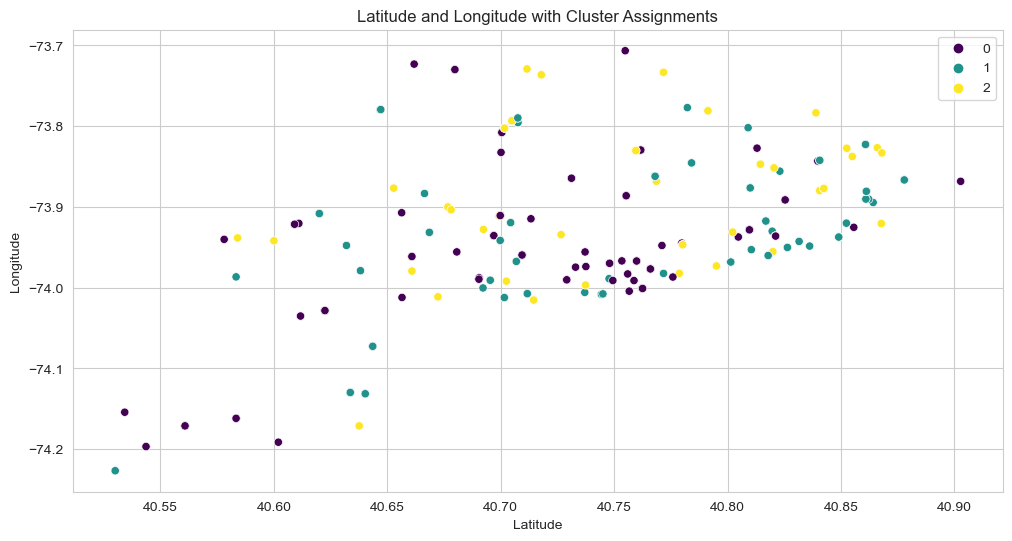

In [972]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'a' is a dictionary of user_id -> cluster assignment
cluster_assignments = np.array([a[user_id] for user_id in locations_df_new[:500]['user_id']])

# Set the figure size
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot the data
sns.scatterplot(x='Dlatitude', y='Dlongitude', data=locations_df_new[:500], 
                hue=cluster_assignments, palette='viridis', legend='full')

# Add plot title and labels
plt.title('Latitude and Longitude with Cluster Assignments')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Show the plot
plt.show()


In [346]:
a = {user_id: np.random.randint(3) for user_id in locations_df_new[:500]['user_id'].unique()}
#turn it into a cluster column for df
locat_Test = locations_df_new[:500].copy()
a.values()
locat_test_unique = locat_Test['user_id'].unique()
locat_Test['cluster'] = locat_Test['user_id'].map(a)


In [348]:
a

{'S53': 2,
 'Q44-SBS': 2,
 'Bx28': 1,
 'M55': 1,
 'B46': 0,
 'B15': 1,
 'M60-SBS': 0,
 'S79-SBS': 0,
 'X27': 0,
 'Q27': 0,
 'Bx24': 2,
 'Bx12': 2,
 'M Shuttle Bus': 1,
 'Q84': 0,
 'B83': 2,
 'Q3': 1,
 'B38': 0,
 'M15': 1,
 'Q48': 0,
 'Q32': 1,
 'X17': 0,
 'Bx1': 0,
 'Q85': 0,
 'B67': 0,
 'Q30': 1,
 'Q54': 1,
 'M11': 1,
 'X10': 0,
 'X1': 0,
 'M96': 1,
 'X28': 0,
 'B14': 1,
 'Q88': 0,
 'Bx22': 2,
 'Bx36': 0,
 'Bx15': 1,
 'Q55': 1,
 'M14D': 2,
 'Bx6': 2,
 'B1': 2,
 'M34-SBS': 2,
 'Q13': 1,
 'Bx19': 0,
 'M50': 0,
 'B43': 2,
 'M5': 0,
 'Q12': 1,
 'Bx42': 0,
 'Bx3': 1,
 'M3': 2,
 'Q58': 1,
 'Bx35': 1,
 'M20': 2,
 'B44': 2,
 'B24': 0,
 'M34A-SBS': 1,
 'Bx13': 1,
 'M7': 1,
 'Bx41': 1,
 'M35': 0,
 'B41': 2,
 'B62': 1,
 'M4': 1,
 'Q56': 1,
 'M103': 2,
 'M101': 0,
 'Q20A': 1,
 'Bx29': 0,
 'M22': 2,
 'S74': 1,
 'B47': 1,
 'M42': 2,
 'M31': 1,
 'B25': 2,
 'B6': 1,
 'S59': 0,
 'Bx21': 0,
 'Bx5': 2,
 'M57': 2,
 'Q43': 1,
 'Q59': 1,
 'Bx31': 0,
 'B11': 2,
 'B60': 1,
 'B68': 2,
 'Q16': 0,
 'M66': 0,
 '

In [347]:
locat_Test

,start_time,user_id,Olatitude,Olongitude,Dlatitude,Dlongitude,end_time,diff,cluster
27,2017-01-12 00:06:00,S53,40.622312,-74.028688,40.640296,-74.131330,2017-01-12 00:10:00,0 days 00:04:00,2
49,2017-01-12 00:06:00,Q44-SBS,40.704907,-73.793306,40.842458,-73.877118,2017-01-12 00:08:00,0 days 00:02:00,2
57,2017-01-12 00:05:00,Bx28,40.864076,-73.894613,40.860826,-73.822669,2017-01-12 00:07:00,0 days 00:02:00,1
65,2017-01-12 00:05:00,M55,40.702420,-74.013049,40.755986,-73.982997,2017-01-12 00:07:00,0 days 00:02:00,1
69,2017-01-12 00:05:00,B46,40.609564,-73.921817,40.709404,-73.959565,2017-01-12 00:07:00,0 days 00:02:00,0
...,...,...,...,...,...,...,...,...,...
9795,2017-01-12 05:06:00,Bx40,40.852352,-73.920231,40.840657,-73.842278,2017-01-12 05:08:00,0 days 00:02:00,1
9808,2017-01-12 05:06:00,Q16,40.760906,-73.827317,40.791352,-73.780952,2017-01-12 05:09:00,0 days 00:03:00,0
9811,2017-01-12 05:06:00,Bx6,40.831341,-73.942674,40.810009,-73.876437,2017-01-12 05:10:00,0 days 00:04:00,2
9819,2017-01-12 05:06:00,B57,40.721061,-73.904087,40.672325,-74.011323,2017-01-12 05:08:00,0 days 00:02:00,0


In [153]:
len(locations_df_new[:500]['user_id'].unique())

122

In [107]:
locations_df_new[(locations_df_new['user_id'] !=3) & (locations_df_new['start_time'] == '2017-01-12 00:06:00')]

,start_time,user_id,Olatitude,Olongitude,Dlatitude,Dlongitude,end_time,diff
27,2017-01-12 00:06:00,S53,40.622312,-74.028688,40.640296,-74.131330,2017-01-12 00:10:00,0 days 00:04:00
49,2017-01-12 00:06:00,Q44-SBS,40.704907,-73.793306,40.842458,-73.877118,2017-01-12 00:08:00,0 days 00:02:00
86,2017-01-12 00:06:00,M60-SBS,40.768386,-73.862535,40.801424,-73.968241,2017-01-12 00:08:00,0 days 00:02:00
122,2017-01-12 00:06:00,S79-SBS,40.583223,-74.161951,40.622521,-74.028343,2017-01-12 00:08:00,0 days 00:02:00
395,2017-01-12 00:06:00,Q3,40.647276,-73.779631,40.707614,-73.795538,2017-01-12 00:09:00,0 days 00:03:00
403,2017-01-12 00:06:00,B38,40.696104,-73.990366,40.713339,-73.914687,2017-01-12 00:08:00,0 days 00:02:00
518,2017-01-12 00:06:00,Q44-SBS,40.704907,-73.793306,40.842458,-73.877118,2017-01-12 00:08:00,0 days 00:02:00
524,2017-01-12 00:06:00,Bx1,40.881188,-73.909336,40.809653,-73.928362,2017-01-12 00:09:00,0 days 00:03:00
542,2017-01-12 00:06:00,Q44-SBS,40.704907,-73.793306,40.842458,-73.877118,2017-01-12 00:13:00,0 days 00:07:00
587,2017-01-12 00:06:00,Q85,40.701747,-73.802398,40.661845,-73.723147,2017-01-12 00:08:00,0 days 00:02:00


In [92]:
user_id_df(locations_df_new[:500],3)

,Medium_North-East,Medium_North-West,Medium_South-East,Medium_South-West,High_North-East,High_North-West,High_South-East,High_South-West,low,medium,high,total,user_id,cluster
0,0,1,0,0,0,3,3,0,0,1,6,7,S53,0
1,0,1,0,0,0,31,23,0,0,1,54,55,Q44-SBS,1
2,0,0,0,0,0,1,3,0,0,0,4,4,Bx28,1
3,0,0,0,0,1,0,0,0,0,0,1,1,M55,2
4,0,0,0,0,0,4,3,0,0,0,7,7,B46,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,0,0,0,0,1,0,0,0,0,0,1,1,X7,0
118,0,0,1,0,0,0,0,0,0,1,0,1,M23-SBS,0
119,0,0,0,0,1,0,0,0,0,0,1,1,X2,2
120,0,0,0,0,0,0,0,0,1,0,0,1,X17J,0


In [89]:
calculate_likelihood_user_cluster(locations_df_new[:500], 0.5, 1, 1, 3)

(0.002291495830694951,
 array([1.85073263e-10, 9.79950557e-17, 2.47018428e-15, 1.74426030e-09,
        9.42331290e-16, 9.10430321e-10, 1.88850268e-11, 2.56402056e-12,
        4.96145151e-07, 1.52415790e-04, 4.96145151e-07, 1.52415790e-04,
        7.82134001e-12, 1.52415790e-04, 1.52415790e-04, 1.52415790e-04,
        1.52415790e-04, 3.87176219e-08, 1.52415790e-04, 8.93061271e-07,
        8.93061271e-07, 4.96145151e-07, 1.80682235e-08, 1.52415790e-04,
        4.08349918e-10, 2.86135244e-10, 3.87176219e-08, 1.52415790e-04,
        4.96145151e-07, 1.52415790e-04, 1.52415790e-04, 1.52415790e-04,
        8.93061271e-07, 1.52415790e-04, 4.96145151e-07, 1.52415790e-04,
        1.52415790e-04]))

In [91]:
sampling_gibbs_whoo_new(locations_df_new[:500], 3, 10, 0.5, 1, 1, '12/1/2024 12:00',3)

past_displacement
              start_time  user_id  Olatitude  Olongitude  Dlatitude  \
27   2017-01-12 00:06:00      S53  40.622312  -74.028688  40.640296   
49   2017-01-12 00:06:00  Q44-SBS  40.704907  -73.793306  40.842458   
57   2017-01-12 00:05:00     Bx28  40.864076  -73.894613  40.860826   
65   2017-01-12 00:05:00      M55  40.702420  -74.013049  40.755986   
69   2017-01-12 00:05:00      B46  40.609564  -73.921817  40.709404   
...                  ...      ...        ...         ...        ...   
9795 2017-01-12 05:06:00     Bx40  40.852352  -73.920231  40.840657   
9808 2017-01-12 05:06:00      Q16  40.760906  -73.827317  40.791352   
9811 2017-01-12 05:06:00      Bx6  40.831341  -73.942674  40.810009   
9819 2017-01-12 05:06:00      B57  40.721061  -73.904087  40.672325   
9823 2017-01-12 05:06:00     Bx35  40.848951  -73.936872  40.825403   

      Dlongitude            end_time            diff  cluster  
27    -74.131330 2017-01-12 00:10:00 0 days 00:04:00        2  
4

ValueError: high <= 0

In [64]:
sampling_gibbs_whoo(locations_df_new[:2000], 3, 10, 1.0, 1.0, 1.0, '12/1/2024 12:00')

TypeError: compute_displacement_type() missing 1 required positional argument: 'k'

In [85]:
locations_df_new[:2000]


,start_time,user_id,Olatitude,Olongitude,Dlatitude,Dlongitude,end_time,diff
27,2017-01-12 00:06:00,S53,40.622312,-74.028688,40.640296,-74.131330,2017-01-12 00:10:00,0 days 00:04:00
49,2017-01-12 00:06:00,Q44-SBS,40.704907,-73.793306,40.842458,-73.877118,2017-01-12 00:08:00,0 days 00:02:00
57,2017-01-12 00:05:00,Bx28,40.864076,-73.894613,40.860826,-73.822669,2017-01-12 00:07:00,0 days 00:02:00
65,2017-01-12 00:05:00,M55,40.702420,-74.013049,40.755986,-73.982997,2017-01-12 00:07:00,0 days 00:02:00
69,2017-01-12 00:05:00,B46,40.609564,-73.921817,40.709404,-73.959565,2017-01-12 00:07:00,0 days 00:02:00
...,...,...,...,...,...,...,...,...
22628,2017-01-12 06:46:00,Bx28,40.861114,-73.822549,40.864203,-73.894529,2017-01-12 06:48:00,0 days 00:02:00
22631,2017-01-12 06:46:00,B46-SBS,40.609564,-73.921817,40.693672,-73.931170,2017-01-12 06:48:00,0 days 00:02:00
22634,2017-01-12 06:47:00,B67,40.706913,-73.967380,40.638191,-73.978944,2017-01-12 06:49:00,0 days 00:02:00
22649,2017-01-12 06:46:00,M14D,40.744841,-74.008147,40.716391,-73.980131,2017-01-12 06:49:00,0 days 00:03:00


In [38]:
compute_displacement_type(locations_df_new[:2000], speed_thresholds)

,user_id,start_time,end_time,distance,speed,speed_level,direction
0,S53,2017-01-12 00:06:00,2017-01-12 00:10:00,8.910427,133.656403,High,North-West
1,Q44-SBS,2017-01-12 00:06:00,2017-01-12 00:08:00,16.834160,505.024786,High,North-West
2,Bx28,2017-01-12 00:05:00,2017-01-12 00:07:00,6.076316,182.289476,High,South-East
3,M55,2017-01-12 00:05:00,2017-01-12 00:07:00,6.467543,194.026292,High,North-East
4,B46,2017-01-12 00:05:00,2017-01-12 00:07:00,11.537378,346.121338,High,North-West
...,...,...,...,...,...,...,...
1995,Bx28,2017-01-12 06:46:00,2017-01-12 06:48:00,6.078292,182.348746,High,North-West
1996,B46-SBS,2017-01-12 06:46:00,2017-01-12 06:48:00,9.373395,281.201851,High,North-West
1997,B67,2017-01-12 06:47:00,2017-01-12 06:49:00,7.693791,230.813734,High,South-West
1998,M14D,2017-01-12 06:46:00,2017-01-12 06:49:00,3.947490,78.949807,Low,Undefined


In [41]:
user_id_df(locations_df_new[:500])

KeyboardInterrupt: 

In [526]:
calculate_likelihood_user_cluster(dft[:500], 1.0, 1, 3,4, date_on)

     Medium_North-East  Medium_North-West  Medium_South-East  \
0                    0                  1                  0   
1                    0                  1                  0   
2                    0                  0                  0   
3                    0                  0                  0   
4                    0                  0                  0   
..                 ...                ...                ...   
117                  0                  0                  0   
118                  0                  0                  1   
119                  0                  0                  0   
120                  0                  0                  0   
121                  0                  0                  0   

     Medium_South-West  High_North-East  High_North-West  High_South-East  \
0                    0                0                3                3   
1                    0                0               31               23   


KeyError: 'cluster'

In [233]:
gps_data

,user_id,timestamp,latitude,longitude
0,1,2024-01-01 10:00:00,51.507400,-0.127800
1,1,2024-01-01 00:26:00,51.507390,-0.127816
2,1,2024-01-04 23:49:00,51.507380,-0.127819
3,1,2024-01-01 02:56:00,43.653200,-79.383200
4,1,2024-01-03 14:26:00,43.653209,-79.383200
...,...,...,...,...
995,100,2024-01-04 20:19:00,43.653194,-79.383157
996,100,2024-01-01 08:37:00,37.774900,-122.419400
997,100,2024-01-06 01:08:00,37.774879,-122.419377
998,100,2024-01-02 19:23:00,19.076000,72.877700


<Axes: xlabel='latitude', ylabel='Count'>

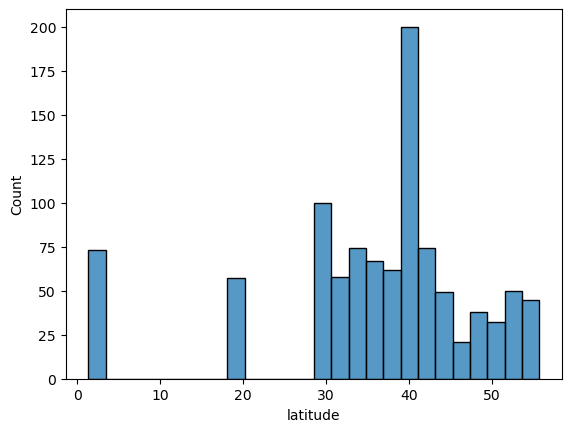

In [232]:
#Plot duplicate latitude + longitude
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(gps_data['latitude'])

In [147]:
gps_data = generate_realistic_gps_data(1000, 100)

In [352]:
#Generate scatterplot based on users with hue as cluster 
cluster = [cluser.get(i) for i in gps_data['user_id']]  
locations_df_new['cluster'] = cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=locations_df_new, x='Olatitude', y='Olongitude', hue='cluster', palette='tab10')
plt.title('GPS Data Clustering')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(title='Cluster')
plt.show()


ValueError: Length of values (990) does not match length of index (33088)

In [156]:
#find duplicates:

gps_data['longitude'].duplicated().sum()

196

In [149]:
#Find duplicate values
gps_data['latitude'].duplicated().sum()

185

<Axes: xlabel='latitude', ylabel='Count'>

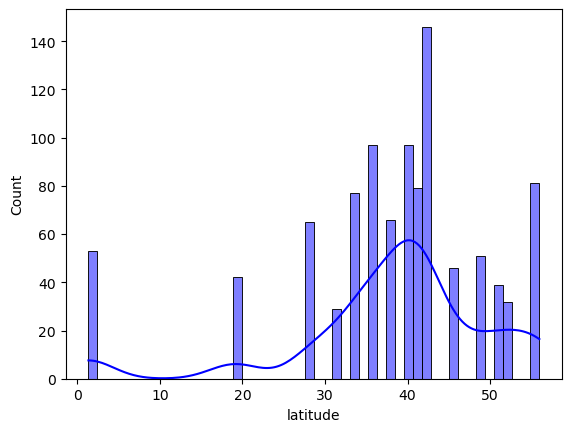

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
#change 
sns.histplot(gps_data['latitude'], bins=50, color='blue', kde=True)



In [102]:
#find duplicates in latitude and longitude:
duplicates = gps_data[gps_data.duplicated(['latitude', 'longitude'], keep=False)]

In [103]:
duplicates

,user_id,timestamp,latitude,longitude
6,1,2024-01-07 04:20:00,34.0522,-118.2437
11,2,2024-01-06 15:14:00,34.0522,-118.2437
13,2,2024-01-05 02:30:00,41.8781,-87.6298
15,2,2024-01-04 17:30:00,34.0522,-118.2437
27,3,2024-01-01 18:06:00,40.7128,-74.0060
...,...,...,...,...
977,98,2024-01-04 01:13:00,41.8781,-87.6298
980,99,2024-01-03 12:58:00,34.0522,-118.2437
983,99,2024-01-04 20:07:00,37.7749,-122.4194
984,99,2024-01-04 12:36:00,34.0522,-118.2437


In [65]:
#Find all users in the same cluster

Same_cluster = {k: v for k, v in cluser.items() if v == 1}

In [70]:
#Get users in same cluster:
users = list(Same_cluster.keys())

In [71]:
users

[5, 7, 8, 9]

In [184]:
randomly_clustered_data = Random_Z_t_u(displacement_data,date_str)

In [186]:
randomly_clustered_data['user_id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [156]:
randomly_clustered_data = Random_Z_t_u(displacement_data,'02.01.2024')
previous_clustered = Random_Z_t_u(displacement_data,'01.01.2024')
user_id = 2
cluster = 1
specific_date = '01.02.2024'
gamma = 1
alpha = .001
beta = 1000
cluster_num = 3
likelihood, prod_per_user = calculate_likelihood_user_cluster(randomly_clustered_data, gamma, user_id,cluster, specific_date)


[15 18 13 13 16 14 11] (7,)


In [160]:
weight_likelihood_cluster_user(randomly_clustered_data, previous_clustered, alpha, beta, cluster,cluster_num,user_id)

0.3346632281049248

We define the prior cluster distribution (The weights from earlier) as the prior distribution used to draw a cluster label k for every subject. A
 widely used prior distribution is the discrete Dirichlet distri
bution, which includes a hyper-parameter that describes prior
 knowledge of the prior distribution. To consider the temporal
 continuity, we utilize the cluster distribution at the previous
 time with a damping factor of by adding up as the hyper
parameter of the discrete Dirichlet distribution:

$$
p(z_u^t = k|Z_{t,-u},Z_{t-1}) = \frac{n_{t,-u}^k + \alpha n_{t-1}^k + \beta}{n_{t,-u}+ \alpha n_{t-1} + \beta K}  
$$

- $n_{t,-u}^k$ -  Number of subjects belong to cluster k except subject u
- $n_{t,-u}$ - total number of subjects at time t except subject u

In [35]:
displacement_data[displacement_data['user_id'] != 1]

,user_id,start_time,end_time,distance,speed,speed_level,direction
99,2,2024-01-01 02:43:00,2024-01-01 04:19:00,0.487165,0.304478,Low,Undefined
100,2,2024-01-01 04:19:00,2024-01-01 05:44:00,1.535216,1.083682,Low,Undefined
101,2,2024-01-01 05:44:00,2024-01-01 06:15:00,3.488015,6.750996,Medium,South-West
102,2,2024-01-01 06:15:00,2024-01-01 11:48:00,4.269322,0.769247,Low,Undefined
103,2,2024-01-01 11:48:00,2024-01-01 11:54:00,0.654503,6.545032,Medium,South-East
...,...,...,...,...,...,...,...
985,10,2024-01-07 13:29:00,2024-01-07 17:26:00,7.531821,1.906790,Low,Undefined
986,10,2024-01-07 17:26:00,2024-01-07 20:13:00,6.668838,2.395990,Low,Undefined
987,10,2024-01-07 20:13:00,2024-01-07 21:02:00,4.664890,5.712110,Medium,North-West
988,10,2024-01-07 21:02:00,2024-01-07 21:19:00,10.335255,36.477371,High,South-East


In [252]:
np.prod(dat, axis = 1)

array([[3.76386136e-15, 2.18312045e-16, 2.84357658e-15, 3.52657918e-16,
        6.10324068e-13, 4.82788516e-13, 2.81768079e-13, 1.29543009e-12,
        3.34017428e-14],
       [3.76386136e-15, 2.18312045e-16, 2.84357658e-15, 3.52657918e-16,
        6.10324068e-13, 4.82788516e-13, 2.81768079e-13, 1.29543009e-12,
        3.34017428e-14],
       [3.76386136e-15, 2.18312045e-16, 2.84357658e-15, 3.52657918e-16,
        6.10324068e-13, 4.82788516e-13, 2.81768079e-13, 1.29543009e-12,
        3.34017428e-14],
       [3.76386136e-15, 2.18312045e-16, 2.84357658e-15, 3.52657918e-16,
        6.10324068e-13, 4.82788516e-13, 2.81768079e-13, 1.29543009e-12,
        3.34017428e-14],
       [3.76386136e-15, 2.18312045e-16, 2.84357658e-15, 3.52657918e-16,
        6.10324068e-13, 4.82788516e-13, 2.81768079e-13, 1.29543009e-12,
        3.34017428e-14],
       [3.76386136e-15, 2.18312045e-16, 2.84357658e-15, 3.52657918e-16,
        6.10324068e-13, 4.82788516e-13, 2.81768079e-13, 1.29543009e-12,
        3.3

 $$
p(x_d|x_o,Z_{t,-u}^k,X_{t,-u}^k) = \frac{n_{I(x_o),D(x_d,x_o)}^k + \gamma}{\sum_{D} n_{I(x_o),D_i(x_D,x_o)}^k + L_i(x_o) \cdot \gamma}
 $$

 #### Markov chain of one specific displacement over all types of displacement (make sure)

In [192]:
df_user_id = user_id_df(displacement_data)

In [201]:
df_user_id

,Medium_North-East,Medium_North-West,Medium_South-East,Medium_South-West,High_North-East,High_North-West,High_South-East,High_South-West,low,medium,high,total,user_id
0,2,3,4,3,10,36,33,6,2,12,85,99,1
1,11,10,10,11,11,7,15,10,14,42,43,99,2
2,2,9,6,3,14,19,22,18,6,20,73,99,3
3,2,14,11,2,1,4,6,0,59,29,11,99,4
4,8,10,9,3,11,24,20,4,10,30,59,99,5
5,8,9,10,12,13,4,8,13,22,39,38,99,6
6,7,9,8,9,12,14,18,14,8,33,58,99,7
7,9,11,13,10,8,14,13,7,14,43,42,99,8
8,8,2,6,8,20,18,13,21,3,24,72,99,9
9,4,6,7,4,7,32,30,7,2,21,76,99,10


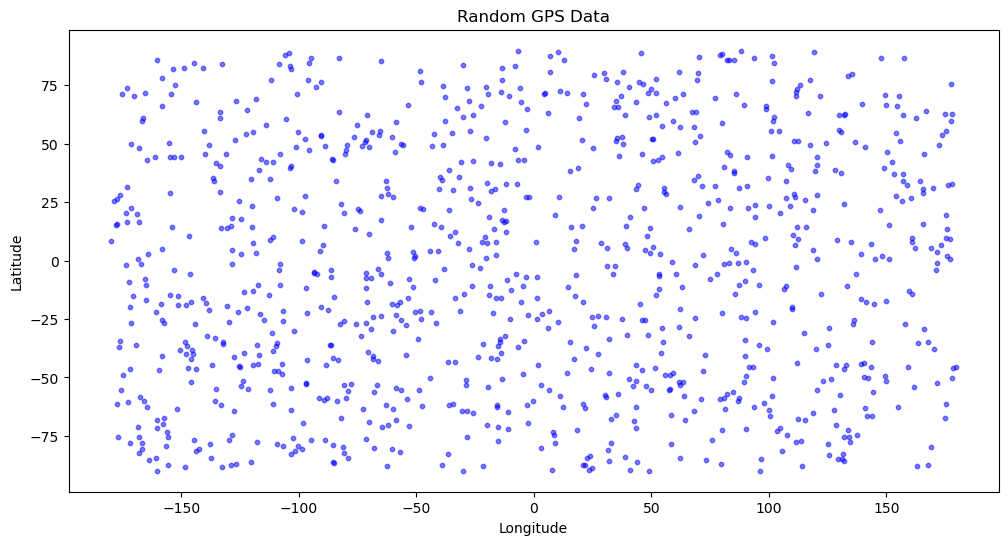

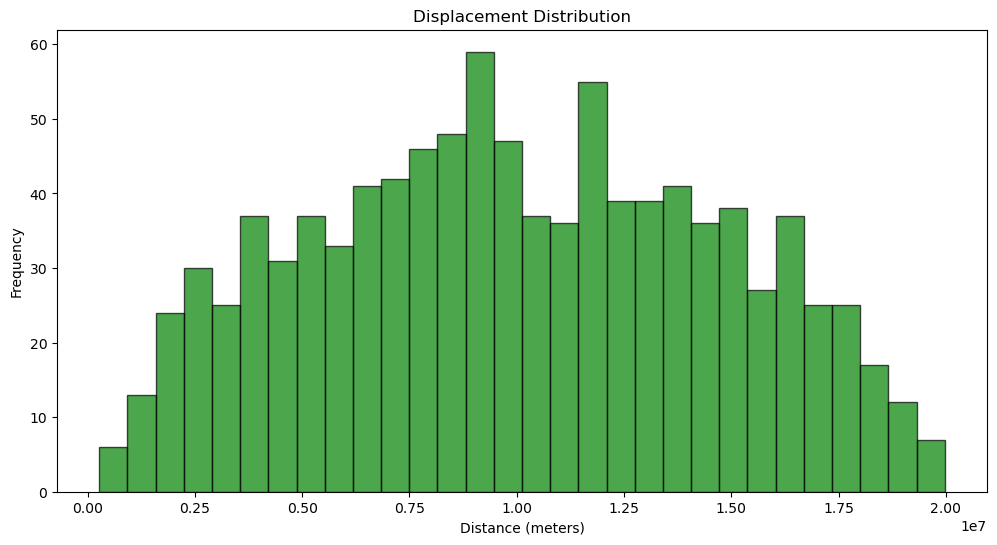

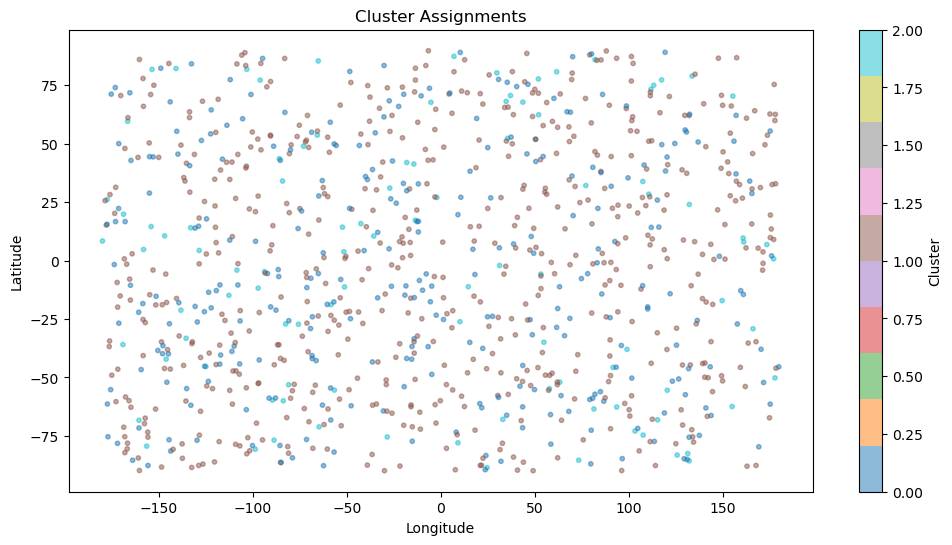

In [158]:
import matplotlib.pyplot as plt

# Function to plot random GPS data
def plot_gps_data(gps_data):
    plt.figure(figsize=(12, 6))
    plt.scatter(gps_data['longitude'], gps_data['latitude'], c='blue', s=10, alpha=0.5)
    plt.title('Random GPS Data')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Function to plot displacement distribution
def plot_displacement_distribution(displacement_data):
    plt.figure(figsize=(12, 6))
    plt.hist(displacement_data['distance'], bins=30, color='green', edgecolor='black', alpha=0.7)
    plt.title('Displacement Distribution')
    plt.xlabel('Distance (meters)')
    plt.ylabel('Frequency')
    plt.show()

# Function to plot cluster assignments
def plot_cluster_assignments(gps_data, cluster_assignments):
    plt.figure(figsize=(12, 6))
    colors = plt.cm.get_cmap('tab10', len(set(cluster_assignments.values())))
    gps_data['cluster'] = gps_data['user_id'].map(cluster_assignments)
    plt.scatter(gps_data['longitude'], gps_data['latitude'], c=gps_data['cluster'], cmap='tab10', s=10, alpha=0.5)
    plt.title('Cluster Assignments')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(label='Cluster')
    plt.show()

# Generate and visualize data
num_records = 1000
num_users = 10
num_clusters = 3
num_iterations = 10
gamma = 1.0
alpha = 1.0
beta = 1.0

# Generate data
gps_data = generate_random_gps_data(num_records, num_users)
displacement_data = calculate_displacements(gps_data)

# Run Gibbs Sampling Inference
cluster_assignments = gibbs_sampling_inference(gps_data, num_clusters, num_iterations, gamma, alpha, beta)

# Plot data
plot_gps_data(gps_data)
plot_displacement_distribution(displacement_data)
plot_cluster_assignments(gps_data, cluster_assignments)


# `Pseudo code 2: Random Walk Sampling predicted people movement`

In [220]:
import numpy as np
import pandas as pd


def Last_location(gps_data):
    # Initialize an empty NumPy array to store the last points
    last_points = np.empty((0, 4), dtype=object)

    # Loop through each unique user_id
    for user_id in gps_data['user_id'].unique():
        # Get the last record for this user
        last_record = gps_data[gps_data['user_id'] == user_id].iloc[-1]
        
        # Create a NumPy array for this last point
        last_point = np.array([[last_record['user_id'], last_record['latitude'], 
                                last_record['longitude'], last_record['timestamp']]], dtype=object)
        
        # Append the new last point to the last_points array
        last_points = np.append(last_points, last_point, axis=0)

    return last_points


def sampling_gibbs_whoo(gps_data, num_clusters, num_iterations, gamma, alpha, beta, specific_date):
    
    return sampling_gibbs_whoo(gps_data, 3,   100, 1.0, 1.0, 1000, date_str)
    
def predicted_location_cluster_based(gps_data):
    last_point = Last_location(gps_data)
    gps_df = sampling_gibbs_whoo(gps_data, 3,   100, 1.0, 1.0, 1000, date_str)
    for user_id in gps_data['user_id'].unique():
        last_location_user = last_point[last_point[:,0] == user_id][:,1:3]
        cluster_user = gps_df.get(user_id)
        Same_cluster = {k: v for k, v in cluser.items() if v == cluster_user}
        users = list(Same_cluster.keys())
        same_cluster_locations = last_point[np.isin(last_point[:, 0], Same_cluster)][:, 1:3]

        # Now get the locations that come after `last_location_user` for those in the same cluster
        possible_next_locations = []
        for uid in Same_cluster:
            user_data = gps_data[gps_data['user_id'] == uid].sort_values(by='timestamp')
            for i in range(len(user_data) - 1):
                current_location = (user_data.iloc[i]['latitude'], user_data.iloc[i]['longitude'])
                next_location = (user_data.iloc[i + 1]['latitude'], user_data.iloc[i + 1]['longitude'])
                if current_location == tuple(last_location_user[0]):
                    possible_next_locations.append(next_location)
        
        if possible_next_locations:
            locations, counts = np.unique(possible_next_locations, axis=0, return_counts=True)
            location_probs = counts / counts.sum()
            
            # Draw the next location based on the multinomial distribution
            predicted_next_location = locations[np.random.choice(len(locations), p=location_probs)]
            predicted_locations[user_id] = predicted_next_location
        else:
            return 0

    return predicted_locations

        


def track_displacements(gps_data):
    """
    Create count tables for displacements between locations and time intervals.
    """
    # Initialize dictionaries to store displacement and time interval counts
    n_l_next_l = {}  # n_{l_{i+1}, l_i} (displacements between locations)
    n_tau_l = {}     # n_{tau, l_i} (time intervals from location l_i)
    n_total_l = {}   # n_{:, l_i} (total number of displacements from l_i)
    gps_data - generate_realistic_gps_data(1000, 10)['user_id', 'timestamp', 'latitude', 'longitude']
    gps_df = sampling_gibbs_whoo(gps_data, 3,   100, 1.0, 1.0, 1000, date_str)
    for user_id in gps_data['user_id'].unique():
        last_point = gps_data[gps_data['user_id'] == user_id].iloc[-1]
        cluster_user = gps_df.get(user_id)
        users_in_cluster = gps_df


    
    # Set 

    return n_l_next_l, n_tau_l, n_total_l

def draw_next_location_and_time(n_l_next_l, n_tau_l, n_total_l, current_location):
    """
    Draw the next location and time interval based on the current location
    using the multinomial distribution.
    """
    if current_location not in n_l_next_l or current_location not in n_tau_l or n_total_l[current_location] == 0:
        return None, None  # No data for this location

    # Extract counts for transitions and time intervals from current location
    location_counts = n_l_next_l[current_location]
    tau_counts = n_tau_l[current_location]

    # Compute multinomial probabilities for the next location
    locations = list(location_counts.keys())
    location_probs = np.array([location_counts[loc] for loc in locations]) / n_total_l[current_location]

    # Draw the next location
    next_location = np.random.choice(locations, p=location_probs)

    # Compute multinomial probabilities for the time intervals
    taus = list(tau_counts.keys())
    tau_probs = np.array([tau_counts[t] for t in taus]) / n_total_l[current_location]

    # Draw the next time interval (bin)
    next_tau_bin = np.random.choice(taus, p=tau_probs)

    # You could also assign time interval from a continuous distribution or bin range as necessary.
    next_time_interval = next_tau_bin  # Assuming the bin itself represents the hours directly.

    return next_location, next_time_interval

def predict_movement_with_displacement(cluster_assignments, gps_data, num_clusters, time_step):
    n_l_next_l, n_tau_l = track_displacements(gps_data)
    predicted_movements = []
    
    # Iterate over each user
    for user_id, cluster in cluster_assignments.items():
        user_data = gps_data[gps_data['user_id'] == user_id]
        
        # Get the last known location of the user
        last_record = user_data.iloc[-1]
        last_location = (last_record['latitude'], last_record['longitude'])
        last_time = last_record['timestamp']
        
        predicted_time = last_time
        predicted_location = last_location
        
        while predicted_time < last_time + timedelta(hours=time_step):
            # Draw next location and time interval based on the current location
            next_location, next_time_interval = draw_next_location_and_time(n_l_next_l, n_tau_l, predicted_location)
            
            if next_location is None or next_time_interval is None:
                break  # No further prediction possible
            
            predicted_time += timedelta(hours=next_time_interval)
            predicted_location = next_location
            
            # Append the predicted movement to the result
            predicted_movements.append((user_id, predicted_time, predicted_location[0], predicted_location[1]))
    
    return pd.DataFrame(predicted_movements, columns=['user_id', 'timestamp', 'latitude', 'longitude'])

# Example usage


In [221]:
location = Last_location(gps_data)

In [88]:
sampling_gibbs_whoo(gps_data, 3,   100, 1.0, 1.0, 1000, date_str)

{1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 2, 7: 0, 8: 0, 9: 2, 10: 0}

In [222]:
predicted_location_cluster_based(gps_data)

0

In [46]:
gps_data = generate_realistic_gps_data(1000, 10)

In [64]:
gps_data[gps_data['user_id']==2]

,user_id,timestamp,latitude,longitude
100,2,2024-01-07 10:13:00,-80.414224,53.658856
101,2,2024-01-03 10:23:00,-80.414220,53.658919
102,2,2024-01-02 05:05:00,-80.414221,53.658912
103,2,2024-01-06 19:14:00,-80.414218,53.658929
104,2,2024-01-01 00:50:00,-80.414212,53.659010
...,...,...,...,...
195,2,2024-01-03 14:11:00,-80.414229,53.657067
196,2,2024-01-07 10:23:00,-80.414193,53.656908
197,2,2024-01-05 19:49:00,-80.414191,53.656923
198,2,2024-01-05 19:45:00,-80.414191,53.656924


In [ ]:
def calculate_likelihood_user_cluster_chat3(randl_df,df, gamma, user_id, cluster,previous_cluster): 
    #users_list = df['user_id'].unique()
    #randl_df = user_id_df(df)
    randl_df['cluster'] = randl_df['user_id'].map(previous_cluster)
    cluster_users = randl_df[randl_df['cluster'] == cluster]['cluster'].unique()
    # Extract unique latitude and longitude vectors for each user
    users_latitude_vec = [df[df['user_id'] == user]['Dlatitude'].unique() for user in cluster_users]
    users_longitude_vec = [df[df['user_id'] == user]['Dlongitude'].unique() for user in cluster_users]
    print(users_latitude_vec)
    
    # Determine total unique end locations (x_o)
    if len(users_latitude_vec) < len(users_longitude_vec):
        total_unique_end_location = users_latitude_vec
    else:
        total_unique_end_location = users_longitude_vec
    
    # Filter out the target user and select users in the same cluster
    user_list = randl_df[randl_df['user_id'] != user_id]
    user_list_c = user_list[user_list['cluster'] == cluster]
    
    # Extract user IDs, total counts, and displacement columns
    total = user_list_c['total'].values
    displacement_cols = user_list_c.iloc[:, :9].values  # Assuming 9 displacement columns
    if displacement_cols.shape[0] == 0 or displacement_cols.shape[1] !=9:
        tot = min(len(displacement_cols),len(total_unique_end_location))
    tot = len(total_unique_end_location)
    # Initialize a list to store the likelihood for each displacement type (9 in total)
    likelihoods = np.zeros(9)
    
    # Loop over all displacement types (D(x_d, x_o)) and calculate likelihood for each
    for i in range(9):  # For each displacement type (i.e., speed + direction combination)
        likelihood_part_sum = 0  # Accumulate the sum for this displacement type
        
        for j in range(total_unique_end_location):  # For each starting location x_o
            # Calculate the likelihood part for the current displacement type and starting location
            # Note that displacement_cols[:, i] gives the count for displacement type i
            likelihood_part = (displacement_cols[j, i] + gamma) / (
                total[j] + len(total_unique_end_location[j]) * gamma)
            
            # Sum the likelihoods across all starting locations for this displacement type
            likelihood_part_sum += np.sum(likelihood_part)
        
        # Store the final likelihood for this displacement type
        likelihoods[i] = likelihood_part_sum
    # Multiply all 9 likelihoods to get the final joint probability (product of all displacement type likelihoods)
    final_likelihood = np.prod(likelihoods)
    
    return min(final_likelihood,1)

def weight_likelihood_cluster_user1(df, alpha, beta, cluster, cluster_num, user_id, specific_date, previous_cluster):
    previous_time = datetime.strptime(specific_date, '%Y-%m-%d %H:%M:%S') - timedelta(hours=1)
    # Reformat the date
    previous_time = previous_time.strftime('%Y-%m-%d %H:%M:%S')
    df['cluster'] = df['user_id'].map(previous_cluster)
    previous_clustered = df[(df['user_id'] != user_id) & (df['start_time'] == previous_time)]
    total_prev = len(previous_clustered['user_id'].unique())
    user_cluster_p = previous_clustered[previous_clustered['cluster'] == cluster]
    users_c_p = user_cluster_p['user_id'].unique()
    cluster_prev_total = len(users_c_p)
    curr_user_df = df[(df['user_id'] != user_id) & (df['start_time'] == specific_date)]
    curr_user_list = curr_user_df['user_id'].unique()
    total_timestamp = len(curr_user_list)
    m_user_cluster_df = curr_user_df[curr_user_df['cluster'] == cluster]
    m_users_c = m_user_cluster_df['user_id']
    cluster_total_timestamp = len(m_users_c)
    weight = (cluster_total_timestamp + alpha * cluster_prev_total + beta) / (total_timestamp + alpha * total_prev + beta * cluster_num)
    return weight